<a href="https://colab.research.google.com/github/kimiaameri/GrammarEnriched/blob/main/Tensorflow_Kears_GrammarEnrichedLM_with%20Grammer%20Masked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [834]:
import math
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import numpy as np
__all__ = [
    'TOKEN_PAD', 'TOKEN_UNK', 'TOKEN_CLS', 'TOKEN_SEP', 'TOKEN_MASK',
    'gelu', 'get_model', 'get_custom_objects', 'get_base_dict', 'gen_batch_inputs',
]


In [835]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preprocess Section

In [836]:
import os
import glob
import gc
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
import pickle
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [837]:
from transformers import BertModel,BertTokenizer 

bert = BertModel.from_pretrained('bert-base-uncased')
modifiedEmbeddings=bert.embeddings.word_embeddings.weight
modifiedEmbeddings=modifiedEmbeddings.cpu().detach().numpy()
modifiedPosiotions=bert.embeddings.position_embeddings.weight
modifiedPosiotions=modifiedPosiotions.cpu().detach().numpy()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [838]:
Newtokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Thesis/uncased_L-12_H-768_A-12', 
                                          do_lower_case=True)

# Embedding similarity Section

In [839]:
from tensorflow import keras
import tensorflow.keras.backend as K

__all__ = ['EmbeddingRet', 'EmbeddingSim', 'get_custom_objects']


class EmbeddingRet(keras.layers.Embedding):
    """Embedding layer with weights returned."""

    def compute_output_shape(self, input_shape):
        return [
            super(EmbeddingRet, self).compute_output_shape(input_shape),
            (self.input_dim, self.output_dim),
        ]

    def compute_mask(self, inputs, mask=None):
        return [
            super(EmbeddingRet, self).compute_mask(inputs, mask),
            None,
        ]

    def call(self, inputs):
        return [
            super(EmbeddingRet, self).call(inputs),
            self.embeddings,
        ]
class EmbeddingSim(keras.layers.Layer):
    """Calculate similarity between features and token embeddings with bias term."""

    def __init__(self,
                 initializer='zeros',
                 regularizer=None,
                 constraint=None,
                 **kwargs):
        """Initialize the layer.
        :param output_dim: Same as embedding output dimension.
        :param initializer: Initializer for bias.
        :param regularizer: Regularizer for bias.
        :param constraint: Constraint for bias.
        :param kwargs: Arguments for parent class.
        """
        super(EmbeddingSim, self).__init__(**kwargs)
        self.supports_masking = True
        self.initializer = keras.initializers.get(initializer)
        self.regularizer = keras.regularizers.get(regularizer)
        self.constraint = keras.constraints.get(constraint)
        self.bias = None

    def get_config(self):
        config = {
            'initializer': keras.initializers.serialize(self.initializer),
            'regularizer': keras.regularizers.serialize(self.regularizer),
            'constraint': keras.constraints.serialize(self.constraint),
        }
        base_config = super(EmbeddingSim, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        self.bias = self.add_weight(
            shape=(input_shape[1][0],),
            initializer=self.initializer,
            regularizer=self.regularizer,
            constraint=self.constraint,
            name='bias',
        )
        super(EmbeddingSim, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + (input_shape[1][0],)

    def compute_mask(self, inputs, mask=None):
        return mask[0]

    def call(self, inputs, mask=None, **kwargs):
        inputs, embeddings = inputs
        outputs = K.bias_add(K.dot(inputs, K.transpose(embeddings)), self.bias)
        return keras.activations.softmax(outputs)
def get_custom_objects():
    return {
        'EmbeddingRet': EmbeddingRet,
        'EmbeddingSim': EmbeddingSim,
    }

In [840]:

# class EmbeddingSim(keras.layers.Layer):
#     """Calculate similarity between features and token embeddings with bias term."""

#     def __init__(self,
#                  use_bias=True,
#                  initializer='zeros',
#                  regularizer=None,
#                  constraint=None,
#                  **kwargs):
#         """Initialize the layer.
#         :param output_dim: Same as embedding output dimension.
#         :param use_bias: Whether to use bias term.
#         :param initializer: Initializer for bias.
#         :param regularizer: Regularizer for bias.
#         :param constraint: Constraint for bias.
#         :param kwargs: Arguments for parent class.
#         """
#         super(EmbeddingSim, self).__init__(**kwargs)
#         self.supports_masking = True
#         self.use_bias = use_bias
#         self.initializer = keras.initializers.get(initializer)
#         self.regularizer = keras.regularizers.get(regularizer)
#         self.constraint = keras.constraints.get(constraint)
#         self.bias = None

#     def get_config(self):
#         config = {
#             'use_bias': self.use_bias,
#             'initializer': keras.initializers.serialize(self.initializer),
#             'regularizer': keras.regularizers.serialize(self.regularizer),
#             'constraint': keras.constraints.serialize(self.constraint),
#         }
#         base_config = super(EmbeddingSim, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

#     def build(self, input_shape):
#         if self.use_bias:
#             embed_shape = input_shape[1]
#             token_num = embed_shape[0]
#             self.bias = self.add_weight(
#                 shape=(token_num,),
#                 initializer=self.initializer,
#                 regularizer=self.regularizer,
#                 constraint=self.constraint,
#                 name='bias',
#             )
#         super(EmbeddingSim, self).build(input_shape)

#     def compute_output_shape(self, input_shape):
#         feature_shape, embed_shape = input_shape
#         token_num = embed_shape[0]
#         return feature_shape[:-1] + (token_num,)

#     def compute_mask(self, inputs, mask=None):
#         return mask[0]

#     def call(self, inputs, mask=None, **kwargs):
#         inputs, embeddings,embeddings_g = inputs
#         output_t = K.dot(inputs, K.transpose(embeddings))
#         output_g = K.dot(inputs, K.transpose(embeddings_g))

#         if self.use_bias:
            
#             outputs = K.bias_add(K.concatenate([output_t,output_g]), self.bias)
#             norm_layer = LayerNormalization(
#             trainable=True,
#             name='Embedding-Norm',
#         )(configuration.hidden_dropout_prob)
#         else:
#             outputs = K.concatenate([output_t,output_g])
#             norm_layer = LayerNormalization(
#             trainable=True,
#             name='Embedding-Norm',
#         )(configuration.hidden_dropout_prob)

#         return keras.activations.softmax(norm_layer)




# layer Normalization Section

In [841]:
class LayerNormalization(keras.layers.Layer):

    def __init__(self,
                 center=True,
                 scale=True,
                 epsilon=None,
                 gamma_initializer='ones',
                 beta_initializer='zeros',
                 gamma_regularizer=None,
                 beta_regularizer=None,
                 gamma_constraint=None,
                 beta_constraint=None,
                 **kwargs):
        """Layer normalization layer
        See: [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf)
        :param center: Add an offset parameter if it is True.
        :param scale: Add a scale parameter if it is True.
        :param epsilon: Epsilon for calculating variance.
        :param gamma_initializer: Initializer for the gamma weight.
        :param beta_initializer: Initializer for the beta weight.
        :param gamma_regularizer: Optional regularizer for the gamma weight.
        :param beta_regularizer: Optional regularizer for the beta weight.
        :param gamma_constraint: Optional constraint for the gamma weight.
        :param beta_constraint: Optional constraint for the beta weight.
        :param kwargs:
        """
        super(LayerNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.center = center
        self.scale = scale
        if epsilon is None:
            epsilon = K.epsilon() * K.epsilon()
        self.epsilon = epsilon
        self.gamma_initializer = keras.initializers.get(gamma_initializer)
        self.beta_initializer = keras.initializers.get(beta_initializer)
        self.gamma_regularizer = keras.regularizers.get(gamma_regularizer)
        self.beta_regularizer = keras.regularizers.get(beta_regularizer)
        self.gamma_constraint = keras.constraints.get(gamma_constraint)
        self.beta_constraint = keras.constraints.get(beta_constraint)
        self.gamma, self.beta = None, None

    def get_config(self):
        config = {
            'center': self.center,
            'scale': self.scale,
            'epsilon': self.epsilon,
            'gamma_initializer': keras.initializers.serialize(self.gamma_initializer),
            'beta_initializer': keras.initializers.serialize(self.beta_initializer),
            'gamma_regularizer': keras.regularizers.serialize(self.gamma_regularizer),
            'beta_regularizer': keras.regularizers.serialize(self.beta_regularizer),
            'gamma_constraint': keras.constraints.serialize(self.gamma_constraint),
            'beta_constraint': keras.constraints.serialize(self.beta_constraint),
        }
        base_config = super(LayerNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        self.input_spec = keras.layers.InputSpec(shape=input_shape)
        shape = input_shape[-1:]
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape,
                initializer=self.gamma_initializer,
                regularizer=self.gamma_regularizer,
                constraint=self.gamma_constraint,
                name='gamma',
            )
        if self.center:
            self.beta = self.add_weight(
                shape=shape,
                initializer=self.beta_initializer,
                regularizer=self.beta_regularizer,
                constraint=self.beta_constraint,
                name='beta',
            )
        super(LayerNormalization, self).build(input_shape)

    def call(self, inputs, training=None):
        mean = K.mean(inputs, axis=-1, keepdims=True)
        variance = K.mean(K.square(inputs - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        outputs = (inputs - mean) / std
        if self.scale:
            outputs *= self.gamma
        if self.center:
            outputs += self.beta
        return outputs

# Layers Section

## Conv Section

In [842]:
class MaskedConv1D(keras.layers.Conv1D):

    def __init__(self, **kwargs):
        super(MaskedConv1D, self).__init__(**kwargs)
        self.supports_masking = True

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            inputs *= K.expand_dims(mask, axis=-1)
        return super(MaskedConv1D, self).call(inputs)

## Embedding Section

In [843]:
class TokenEmbedding(keras.layers.Embedding):
    """Embedding layer with weights returned."""

    def compute_output_shape(self, input_shape):
        return [super(TokenEmbedding, self).compute_output_shape(input_shape), (self.input_dim, self.output_dim)]

    def compute_mask(self, inputs, mask=None):
        return [super(TokenEmbedding, self).compute_mask(inputs, mask), None]

    def call(self, inputs):
        return [super(TokenEmbedding, self).call(inputs), self.embeddings]

class GrammarEmbedding(keras.layers.Embedding):
    """Embedding layer with weights returned."""

    def compute_output_shape(self, input_shape):
        return [super(GrammarEmbedding, self).compute_output_shape(input_shape), (self.input_dim, self.output_dim)]

    def compute_mask(self, inputs, mask=None):
        return [super(GrammarEmbedding, self).compute_mask(inputs, mask), None]

    def call(self, inputs):
        return [super(GrammarEmbedding, self).call(inputs), self.embeddings]



def get_embedding(inputs, token_num, grammar_num,pos_num, embed_dim, dropout_rate=0.1, trainable=True):
    """Get embedding layer.
    See: https://arxiv.org/pdf/1810.04805.pdf
    :param inputs: Input layers.
    :param token_num: Number of tokens.
    :param grammar_num: Number of grammars.
    :param pos_num: Maximum position.
    :param embed_dim: The dimension of all embedding layers.
    :param dropout_rate: Dropout rate.
    :param trainable: Whether the layers are trainable.
    :return: The merged embedding layer and weights of token embedding.
    """
    embeddings = [
        TokenEmbedding(
            input_dim=token_num,
            output_dim=embed_dim,
            mask_zero=True,
            trainable=trainable,
            name='Embedding-Token',
        )(inputs[0]),
        keras.layers.Embedding(
            input_dim=2,
            output_dim=embed_dim,
            trainable=trainable,
            name='Embedding-Segment',
        )(inputs[2]),
    ]
    embeddings[0], embed_weights = embeddings[0]
    embed_layer1 = keras.layers.Add(name='Embedding-Token-Segment')(embeddings)

    embeddings_g = [
        GrammarEmbedding(
            input_dim=grammar_num,
            output_dim=embed_dim,
            mask_zero=True,
            trainable=trainable,
            name='Embedding-Grammar',
        )(inputs[1]),
        keras.layers.Embedding(
            input_dim=2,
            output_dim=embed_dim,
            trainable=trainable,
            name='Grammar-Segment',
        )(inputs[2]),
    ]
    embeddings_g[0], embed_G_weights = embeddings_g[0]
    embed_layer2 = keras.layers.Add(name='Embedding-Grammar-Segment')(embeddings_g)

    embed_layer = keras.layers.Add(name='Embedding-Grammar_Token-Segment')([embed_layer1,embed_layer2])

    embed_layer = PositionEmbedding(
        input_dim=pos_num,
        output_dim=embed_dim,
        mode=PositionEmbedding.MODE_ADD,
        trainable=trainable,
        name='Embedding-Position',
    )(embed_layer)
    if dropout_rate > 0.0:
        dropout_layer = keras.layers.Dropout(
            rate=dropout_rate,
            name='Embedding-Dropout',
        )(embed_layer)
    else:
        dropout_layer = embed_layer
    norm_layer = LayerNormalization(
        trainable=trainable,
        name='Embedding-Norm',
    )(dropout_layer)
    return norm_layer, embed_weights,embed_G_weights



In [844]:
class EmbeddingSimilarityToken(keras.layers.Layer):
    """Calculate similarity between features and token embeddings with bias term."""

    def __init__(self,
                 initializer='zeros',
                 regularizer=None,
                 constraint=None,
                 **kwargs):
        """Initialize the layer.
        :param output_dim: Same as embedding output dimension.
        :param initializer: Initializer for bias.
        :param regularizer: Regularizer for bias.
        :param constraint: Constraint for bias.
        :param kwargs: Arguments for parent class.
        """
        super(EmbeddingSimilarityToken, self).__init__(**kwargs)
        self.supports_masking = True
        self.initializer = keras.initializers.get(initializer)
        self.regularizer = keras.regularizers.get(regularizer)
        self.constraint = keras.constraints.get(constraint)
        self.bias = None

    def get_config(self):
        config = {
            'initializer': keras.initializers.serialize(self.initializer),
            'regularizer': keras.regularizers.serialize(self.regularizer),
            'constraint': keras.constraints.serialize(self.constraint),
        }
        base_config = super(EmbeddingSimilarityToken, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        self.bias = self.add_weight(
            shape=(input_shape[1][0],),
            initializer=self.initializer,
            regularizer=self.regularizer,
            constraint=self.constraint,
            name='bias',
        )
        super(EmbeddingSimilarityToken, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + (input_shape[1][0],)

    def compute_mask(self, inputs, mask=None):
        return mask[0]

    def call(self, inputs, mask=None, **kwargs):
        inputs, embeddings = inputs

        outputs = K.bias_add(K.dot(inputs, K.transpose(embeddings)), self.bias)
        return keras.activations.softmax(outputs)


In [845]:
class EmbeddingSimilarityGrammar(keras.layers.Layer):
    """Calculate similarity between features and token embeddings with bias term."""

    def __init__(self,
                 initializer='zeros',
                 regularizer=None,
                 constraint=None,
                 **kwargs):
        """Initialize the layer.
        :param output_dim: Same as embedding output dimension.
        :param initializer: Initializer for bias.
        :param regularizer: Regularizer for bias.
        :param constraint: Constraint for bias.
        :param kwargs: Arguments for parent class.
        """
        super(EmbeddingSimilarityGrammar, self).__init__(**kwargs)
        self.supports_masking = True
        self.initializer = keras.initializers.get(initializer)
        self.regularizer = keras.regularizers.get(regularizer)
        self.constraint = keras.constraints.get(constraint)
        self.bias = None

    def get_config(self):
        config = {
            'initializer': keras.initializers.serialize(self.initializer),
            'regularizer': keras.regularizers.serialize(self.regularizer),
            'constraint': keras.constraints.serialize(self.constraint),
        }
        base_config = super(EmbeddingSimilarityGrammar, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        self.bias = self.add_weight(
            shape=(input_shape[1][0],),
            initializer=self.initializer,
            regularizer=self.regularizer,
            constraint=self.constraint,
            name='bias',
        )
        super(EmbeddingSimilarityGrammar, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + (input_shape[1][0],)

    def compute_mask(self, inputs, mask=None):
        return mask[0]

    def call(self, inputs, mask=None, **kwargs):
        inputs, embeddings = inputs

        outputs = K.bias_add(K.dot(inputs, K.transpose(embeddings)), self.bias)
        return keras.activations.softmax(outputs)


## Extract Section

In [846]:
class Extract(keras.layers.Layer):
    """Extract from index.
    See: https://arxiv.org/pdf/1810.04805.pdf
    """

    def __init__(self, index, **kwargs):
        super(Extract, self).__init__(**kwargs)
        self.index = index
        self.supports_masking = True

    def get_config(self):
        config = {
            'index': self.index,
        }
        base_config = super(Extract, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape[:1] + input_shape[2:]

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        return x[:, self.index]

## Inputs Section

In [847]:
def get_inputs(seq_len):
    """Get input layers.
    See: https://arxiv.org/pdf/1810.04805.pdf
    :param seq_len: Length of the sequence or None.
    """
    names = ['Token','Grammar', 'Segment', 'Masked']
    return [keras.layers.Input(
        shape=(seq_len,),
        name='Input-%s' % name,
    ) for name in names]

## Masked Section

In [848]:
class Masked(keras.layers.Layer):
    """Generate output mask based on the given mask.
    The inputs for the layer is the original input layer and the masked locations.
    See: https://arxiv.org/pdf/1810.04805.pdf
    """

    def __init__(self,
                 return_masked=False,
                 **kwargs):
        """Initialize the layer.
        :param return_masked: Whether to return the merged mask.
        :param kwargs: Arguments for parent class.
        """
        super(Masked, self).__init__(**kwargs)
        self.supports_masking = True
        self.return_masked = return_masked

    def get_config(self):
        config = {
            'return_masked': self.return_masked,
        }
        base_config = super(Masked, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if self.return_masked:
            return [input_shape[0], input_shape[0][:-1]]
        return input_shape[0]

    def compute_mask(self, inputs, mask=None):
        token_mask = K.not_equal(inputs[1], 0)
        return K.all(K.stack([token_mask, mask[0]], axis=0), axis=0)

    def call(self, inputs, mask=None, **kwargs):
        if self.return_masked:
            return [inputs[0], K.cast(self.compute_mask(inputs, mask), K.floatx())]
        return inputs[0]

## Pooling Section

In [849]:
class MaskedGlobalMaxPool1D(keras.layers.Layer):

    def __init__(self, **kwargs):
        super(MaskedGlobalMaxPool1D, self).__init__(**kwargs)
        self.supports_masking = True

    def compute_mask(self, inputs, mask=None):
        return None

    def compute_output_shape(self, input_shape):
        return input_shape[:-2] + (input_shape[-1],)

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            inputs -= K.expand_dims((1.0 - mask) * 1e6, axis=-1)
        return K.max(inputs, axis=-2)

# Multi Head Attention Section

## multi head Section

In [850]:
import copy
class MultiHead(keras.layers.Wrapper):

    def __init__(self,
                 layer,
                 layer_num=6,
                 hidden_dim=None,
                 use_bias=True,
                 reg_index=None,
                 reg_slice=None,
                 reg_factor=0.0,
                 **kwargs):
        """Initialize the wrapper layer.
        :param layer: The layer to be duplicated or a list of layers.
        :param layer_num: The number of duplicated layers.
        :param hidden_dim: A linear transformation will be applied to the input data if provided, otherwise the original
                           data will be feed to the sub-layers.
        :param use_bias: Whether to use bias in the linear transformation.
        :param reg_index: The index of weights to be regularized.
        :param reg_slice: The slice indicates which part of the weight to be regularized.
        :param reg_factor: The weights of the regularization.
        :param kwargs: Arguments for parent.
        """
        if type(layer) is list:
            self.layer = layer[0]
            self.layers = layer
            self.layer_num = len(self.layers)
            self.rename = False
        else:
            self.layer = layer
            self.layers = []
            self.layer_num = layer_num
            self.rename = True
        self.hidden_dim = hidden_dim
        self.use_bias = use_bias
        if reg_index is None or type(reg_index) is list:
            self.reg_index = reg_index
        else:
            self.reg_index = [reg_index]
        if type(reg_slice) is list or reg_index is None:
            self.reg_slice = reg_slice
        else:
            self.reg_slice = [reg_slice] * len(self.reg_index)
        if reg_factor is None or type(reg_factor) is list or reg_index is None:
            self.reg_weight = reg_factor
        else:
            self.reg_weight = [reg_factor] * len(self.reg_index)

        self.W, self.b = None, None
        self.supports_masking = self.layer.supports_masking
        super(MultiHead, self).__init__(self.layer, **kwargs)

    def get_config(self):
        slices = None
        if self.reg_slice:
            slices = []
            for interval in self.reg_slice:
                if interval is None:
                    slices.append(None)
                elif type(interval) is slice:
                    slices.append([interval.start, interval.stop, interval.step])
                else:
                    slices.append([])
                    for sub in interval:
                        slices[-1].append([sub.start, sub.stop, sub.step])
        config = {
            'layers': [],
            'hidden_dim': self.hidden_dim,
            'use_bias': self.use_bias,
            'reg_index': self.reg_index,
            'reg_slice': slices,
            'reg_factor': self.reg_weight,
        }
        for layer in self.layers:
            config['layers'].append({
                'class_name': layer.__class__.__name__,
                'config': layer.get_config(),
            })
        base_config = super(MultiHead, self).get_config()
        base_config.pop('layer')
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config, custom_objects=None):
        reg_slice = config.pop('reg_slice')
        if reg_slice is not None:
            slices = []
            for interval in reg_slice:
                if interval is None:
                    slices.append(None)
                elif type(interval[0]) is list:
                    slices.append([])
                    for sub in interval:
                        slices[-1].append(slice(sub[0], sub[1], sub[2]))
                    slices[-1] = tuple(slices[-1])
                else:
                    slices.append(slice(interval[0], interval[1], interval[2]))
            reg_slice = slices
        layers = [keras.layers.deserialize(layer, custom_objects=custom_objects) for layer in config.pop('layers')]
        return cls(layers, reg_slice=reg_slice, **config)

    def build(self, input_shape):
        if type(input_shape) == list:
            self.input_spec = list(map(lambda x: keras.engine.InputSpec(shape=x), input_shape))
        else:
            self.input_spec = keras.engine.InputSpec(shape=input_shape)
        if not self.layers:
            self.layers = [copy.deepcopy(self.layer) for _ in range(self.layer_num)]
        if self.hidden_dim is not None:
            self.W = self.add_weight(
                shape=(input_shape[-1], self.hidden_dim * self.layer_num),
                name='{}_W'.format(self.name),
                initializer=keras.initializers.get('uniform'),
            )
            if self.use_bias:
                self.b = self.add_weight(
                    shape=(self.hidden_dim * self.layer_num,),
                    name='{}_b'.format(self.name),
                    initializer=keras.initializers.get('zeros'),
                )
            input_shape = input_shape[:-1] + (self.hidden_dim,)
        for i, layer in enumerate(self.layers):
            if not layer.built:
                if self.rename:
                    layer.name = layer.name + '_%d' % (i + 1)
                layer.build(input_shape)
        if self.reg_index:
            for i, (index, interval, weight) in enumerate(zip(self.reg_index, self.reg_slice, self.reg_weight)):
                weights = []
                if type(interval) is slice:
                    interval = (interval,)
                for layer in self.layers:
                    if interval is None:
                        weights.append(K.flatten(layer.get_weights()[index]))
                    else:
                        weights.append(K.flatten(layer.get_weights()[index][interval]))
                weights = K.stack(weights)
                self.add_loss(weight * K.sum(K.square(K.dot(weights, K.transpose(weights)) - K.eye(len(self.layers)))))
        super(MultiHead, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        if self.hidden_dim is not None:
            input_shape = input_shape[:-1] + (self.hidden_dim,)
        child_output_shape = self.layers[0].compute_output_shape(input_shape)
        return child_output_shape + (self.layer_num,)

    def compute_mask(self, inputs, mask=None):
        return self.layers[0].compute_mask(inputs, mask)

    def call(self, inputs, training=None, mask=None):
        kwargs = {}
        if keras.utils.generic_utils.has_arg(self.layer.call, 'training'):
            kwargs['training'] = training
        if keras.utils.generic_utils.has_arg(self.layer.call, 'mask') and mask is not None:
            kwargs['mask'] = mask
        if self.hidden_dim is None:
            outputs = [K.expand_dims(layer.call(inputs, **kwargs)) for layer in self.layers]
        else:
            outputs = []
            for i, layer in enumerate(self.layers):
                begin = i * self.hidden_dim
                end = begin + self.hidden_dim
                transformed = K.dot(inputs, self.W[:, begin:end])
                if self.use_bias:
                    transformed += self.b[begin:end]
                outputs.append(K.expand_dims(layer.call(transformed, **kwargs)))
        return K.concatenate(outputs, axis=-1)

    @property
    def trainable_weights(self):
        weights = self._trainable_weights[:]
        for layer in self.layers:
            weights += layer.trainable_weights
        return weights

    @property
    def non_trainable_weights(self):
        weights = self._non_trainable_weights[:]
        for layer in self.layers:
            weights += layer.non_trainable_weights
        return weights

    @property
    def updates(self):
        updates = self._updates
        for layer in self.layers:
            if hasattr(layer, 'updates'):
                updates += layer.updates
        return []

    def get_updates_for(self, inputs=None):
        inner_inputs = inputs
        if inputs is not None:
            uid = keras.utils.generic_utils.object_list_uid(inputs)
            if uid in self._input_map:
                inner_inputs = self._input_map[uid]

        updates = self._updates
        for layer in self.layers:
            layer_updates = layer.get_updates_for(inner_inputs)
            layer_updates += super(MultiHead, self).get_updates_for(inputs)
            updates += layer_updates
        return updates

    @property
    def losses(self):
        losses = self._losses
        for layer in self.layers:
            if hasattr(layer, 'losses'):
                losses += layer.losses
        return losses

    def get_losses_for(self, inputs=None):
        if inputs is None:
            losses = []
            for layer in self.layers:
                losses = layer.get_losses_for(None)
            return losses + super(MultiHead, self).get_losses_for(None)
        return super(MultiHead, self).get_losses_for(inputs)

## muti head attention Section

In [851]:
class MultiHeadAttention(keras.layers.Layer):
    """Multi-head attention layer.
    See: https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self,
                 head_num,
                 activation='gelu_new',
                 use_bias=True,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 history_only=False,
                 **kwargs):
        """Initialize the layer.
        :param head_num: Number of heads.
        :param activation: Activations for linear mappings.
        :param use_bias: Whether to use bias term.
        :param kernel_initializer: Initializer for linear mappings.
        :param bias_initializer: Initializer for linear mappings.
        :param kernel_regularizer: Regularizer for linear mappings.
        :param bias_regularizer: Regularizer for linear mappings.
        :param kernel_constraint: Constraints for linear mappings.
        :param bias_constraint: Constraints for linear mappings.
        :param history_only: Whether to only use history in attention layer.
        """
        self.supports_masking = True
        self.head_num = head_num
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.history_only = history_only

        self.Wq, self.Wk, self.Wv, self.Wo, self.Wg= None, None, None, None, None
        self.bq, self.bk, self.bv, self.bo , self.bg = None, None, None, None, None
        super(MultiHeadAttention, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'head_num': self.head_num,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'bias_initializer': keras.initializers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
            'history_only': self.history_only,
        }
        base_config = super(MultiHeadAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            q, k, v = input_shape
            return q[:-1] + (v[-1],)
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        if isinstance(input_mask, list):
            return input_mask[0]
        return input_mask

    def build(self, input_shape):
        if isinstance(input_shape, list):
            q, k, v = input_shape
        else:
            q = k = v = input_shape
        feature_dim = v[-1]
        if feature_dim % self.head_num != 0:
            raise IndexError('Invalid head number %d with the given input dim %d' % (self.head_num, feature_dim))
        self.Wq = self.add_weight(
            shape=(q[-1], feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wq' % self.name,
        )
        if self.use_bias:
            self.bq = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bq' % self.name,
            )
        self.Wk = self.add_weight(
            shape=(k[-1], feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wk' % self.name,
        )
        if self.use_bias:
            self.bk = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bk' % self.name,
            )
        self.Wv = self.add_weight(
            shape=(v[-1], feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wv' % self.name,
        )
        if self.use_bias:
            self.bv = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bv' % self.name,
            )
        self.Wg = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wg' % self.name,
        )
        if self.use_bias:
            self.bg = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bg' % self.name,
            )

        self.Wo = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wo' % self.name,
        )
        if self.use_bias:
            self.bo = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bo' % self.name,
            )
        super(MultiHeadAttention, self).build(input_shape)

    @staticmethod
    def _reshape_to_batches(x, head_num):
        input_shape = K.shape(x)
        batch_size, seq_len, feature_dim = input_shape[0], input_shape[1], input_shape[2]
        head_dim = feature_dim // head_num
        x = K.reshape(x, (batch_size, seq_len, head_num, head_dim))
        x = K.permute_dimensions(x, [0, 2, 1, 3])
        return K.reshape(x, (batch_size * head_num, seq_len, head_dim))

    @staticmethod
    def _reshape_from_batches(x, head_num):
        input_shape = K.shape(x)
        batch_size, seq_len, feature_dim = input_shape[0], input_shape[1], input_shape[2]
        x = K.reshape(x, (batch_size // head_num, head_num, seq_len, feature_dim))
        x = K.permute_dimensions(x, [0, 2, 1, 3])
        return K.reshape(x, (batch_size // head_num, seq_len, feature_dim * head_num))

    @staticmethod
    def _reshape_mask(mask, head_num):
        if mask is None:
            return mask
        seq_len = K.shape(mask)[1]
        mask = K.expand_dims(mask, axis=1)
        mask = K.tile(mask, [1, head_num, 1])
        return K.reshape(mask, (-1, seq_len))

    def call(self, inputs, mask=None):
        if isinstance(inputs, list):
            q, k, v, g = inputs
        else:
            q = k = v = g = inputs
        if isinstance(mask, list):
            q_mask, k_mask, v_mask, g_mask = mask
        else:
            q_mask = k_mask = v_mask = g_mask = mask
        q = K.dot(q, self.Wq)
        k = K.dot(k, self.Wk)
        v = K.dot(v, self.Wv)
        g = K.dot(g, self.Wg)
        if self.use_bias:
            q += self.bq
            k += self.bk
            v += self.bv
            g += self.bg
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)
            g = self.activation(g)
        y = ScaledDotProductAttention(
            history_only=self.history_only,
            name='%s-Attention' % self.name,
        )(
            inputs=[
                self._reshape_to_batches(q, self.head_num),
                self._reshape_to_batches(k, self.head_num),
                self._reshape_to_batches(v, self.head_num),
                self._reshape_to_batches(g, self.head_num),
            ],
            mask=[
                self._reshape_mask(q_mask, self.head_num),
                self._reshape_mask(k_mask, self.head_num),
                self._reshape_mask(v_mask, self.head_num),
                self._reshape_mask(g_mask, self.head_num),
            ],
        )
        y = self._reshape_from_batches(y, self.head_num)
        y = K.dot(y, self.Wo)
        if self.use_bias:
            y += self.bo
        if self.activation is not None:
            y = self.activation(y)
        return y

# pointwise feed forward Section

In [852]:
class FeedForward(keras.layers.Layer):
    """Point-wise feed-forward layer.
    See: https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self,
                 units,
                 activation='gelu',
                 use_bias=True,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """Initialize the layer.
        :param units: Dimension of hidden units.
        :param activation: Activation for the first linear transformation.
        :param use_bias: Whether to use the bias term.
        :param kernel_initializer: Initializer for kernels.
        :param bias_initializer: Initializer for kernels.
        :param kernel_regularizer: Regularizer for kernels.
        :param bias_regularizer: Regularizer for kernels.
        :param kernel_constraint: Constraint for kernels.
        :param bias_constraint: Constraint for kernels.
        :param kwargs:
        """
        self.supports_masking = True
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None
        super(FeedForward, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'bias_initializer': keras.initializers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
        }
        base_config = super(FeedForward, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.W1 = self.add_weight(
            shape=(feature_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='{}_W1'.format(self.name),
        )
        if self.use_bias:
            self.b1 = self.add_weight(
                shape=(self.units,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='{}_b1'.format(self.name),
            )
        self.W2 = self.add_weight(
            shape=(self.units, feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='{}_W2'.format(self.name),
        )
        if self.use_bias:
            self.b2 = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='{}_b2'.format(self.name),
            )
        super(FeedForward, self).build(input_shape)

    def call(self, x, mask=None):
        h = K.dot(x, self.W1)
        if self.use_bias:
            h = K.bias_add(h, self.b1)
        if self.activation is not None:
            h = self.activation(h)
        y = K.dot(h, self.W2)
        if self.use_bias:
            y = K.bias_add(y, self.b2)
        return y

# position embedding Section

In [853]:
class PositionEmbedding(keras.layers.Layer):
    """Turn integers (positions) into dense vectors of fixed size.
    eg. [[-4], [10]] -> [[0.25, 0.1], [0.6, -0.2]]
    Expand mode: negative integers (relative position) could be used in this mode.
        # Input shape
            2D tensor with shape: `(batch_size, sequence_length)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, output_dim)`.
    Add mode:
        # Input shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
    Concat mode:
        # Input shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim + output_dim)`.
    """
    MODE_EXPAND = 'expand'
    MODE_ADD = 'add'
    MODE_CONCAT = 'concat'

    def __init__(self,
                 input_dim,
                 output_dim,
                 mode=MODE_EXPAND,
                 embeddings_initializer='uniform',
                 embeddings_regularizer=None,
                 activity_regularizer=None,
                 embeddings_constraint=None,
                 mask_zero=False,
                 **kwargs):
        """
        :param input_dim: The maximum absolute value of positions.
        :param output_dim: The embedding dimension.
        :param embeddings_initializer:
        :param embeddings_regularizer:
        :param activity_regularizer:
        :param embeddings_constraint:
        :param mask_zero: The index that represents padding. Only works in `append` mode.
        :param kwargs:
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.mode = mode
        self.embeddings_initializer = keras.initializers.get(embeddings_initializer)
        self.embeddings_regularizer = keras.regularizers.get(embeddings_regularizer)
        self.activity_regularizer = keras.regularizers.get(activity_regularizer)
        self.embeddings_constraint = keras.constraints.get(embeddings_constraint)
        self.mask_zero = mask_zero
        self.supports_masking = mask_zero is not False

        self.embeddings = None
        super(PositionEmbedding, self).__init__(**kwargs)

    def get_config(self):
        config = {'input_dim': self.input_dim,
                  'output_dim': self.output_dim,
                  'mode': self.mode,
                  'embeddings_initializer': keras.initializers.serialize(self.embeddings_initializer),
                  'embeddings_regularizer': keras.regularizers.serialize(self.embeddings_regularizer),
                  'activity_regularizer': keras.regularizers.serialize(self.activity_regularizer),
                  'embeddings_constraint': keras.constraints.serialize(self.embeddings_constraint),
                  'mask_zero': self.mask_zero}
        base_config = super(PositionEmbedding, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if self.mode == self.MODE_EXPAND:
            self.embeddings = self.add_weight(
                shape=(self.input_dim * 2 + 1, self.output_dim),
                initializer=self.embeddings_initializer,
                name='embeddings',
                regularizer=self.embeddings_regularizer,
                constraint=self.embeddings_constraint,
            )
        else:
            self.embeddings = self.add_weight(
                shape=(self.input_dim, self.output_dim),
                initializer=self.embeddings_initializer,
                name='embeddings',
                regularizer=self.embeddings_regularizer,
                constraint=self.embeddings_constraint,
            )
        super(PositionEmbedding, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        if self.mode == self.MODE_EXPAND:
            if self.mask_zero:
                output_mask = K.not_equal(inputs, self.mask_zero)
            else:
                output_mask = None
        else:
            output_mask = mask
        return output_mask

    def compute_output_shape(self, input_shape):
        if self.mode == self.MODE_EXPAND:
            return input_shape + (self.output_dim,)
        if self.mode == self.MODE_CONCAT:
            return input_shape[:-1] + (input_shape[-1] + self.output_dim,)
        return input_shape

    def call(self, inputs, **kwargs):
        if self.mode == self.MODE_EXPAND:
            if K.dtype(inputs) != 'int32':
                inputs = K.cast(inputs, 'int32')
            return K.gather(
                self.embeddings,
                K.minimum(K.maximum(inputs, -self.input_dim), self.input_dim) + self.input_dim,
            )
        input_shape = K.shape(inputs)
        if self.mode == self.MODE_ADD:
            batch_size, seq_len, output_dim = input_shape[0], input_shape[1], input_shape[2]
        else:
            batch_size, seq_len, output_dim = input_shape[0], input_shape[1], self.output_dim
        pos_embeddings = K.tile(
            K.expand_dims(self.embeddings[:seq_len, :self.output_dim], axis=0),
            [batch_size, 1, 1],
        )
        if self.mode == self.MODE_ADD:
            return inputs + pos_embeddings
        return K.concatenate([inputs, pos_embeddings], axis=-1)

In [854]:
class TrigPosEmbedding(keras.layers.Layer):
    """Position embedding use sine and cosine functions.
    See: https://arxiv.org/pdf/1706.03762
    Expand mode:
        # Input shape
            2D tensor with shape: `(batch_size, sequence_length)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, output_dim)`.
    Add mode:
        # Input shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
    Concat mode:
        # Input shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim)`.
        # Output shape
            3D tensor with shape: `(batch_size, sequence_length, feature_dim + output_dim)`.
    """
    MODE_EXPAND = 'expand'
    MODE_ADD = 'add'
    MODE_CONCAT = 'concat'

    def __init__(self,
                 mode=MODE_ADD,
                 output_dim=None,
                 **kwargs):
        """
        :param output_dim: The embedding dimension.
        :param kwargs:
        """
        if mode in [self.MODE_EXPAND, self.MODE_CONCAT]:
            if output_dim is None:
                raise NotImplementedError('`output_dim` is required in `%s` mode' % mode)
            if output_dim % 2 != 0:
                raise NotImplementedError('It does not make sense to use an odd output dimension: %d' % output_dim)
        self.mode = mode
        self.output_dim = output_dim
        self.supports_masking = True
        super(TrigPosEmbedding, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'mode': self.mode,
            'output_dim': self.output_dim,
        }
        base_config = super(TrigPosEmbedding, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask=None):
        return mask

    def compute_output_shape(self, input_shape):
        if self.mode == self.MODE_EXPAND:
            return input_shape + (self.output_dim,)
        if self.mode == self.MODE_CONCAT:
            return input_shape[:-1] + (input_shape[-1] + self.output_dim,)
        return input_shape

    def call(self, inputs, mask=None):
        input_shape = K.shape(inputs)
        if self.mode == self.MODE_ADD:
            batch_size, seq_len, output_dim = input_shape[0], input_shape[1], input_shape[2]
            pos_input = K.tile(K.expand_dims(K.arange(seq_len), axis=0), [batch_size, 1])
        elif self.mode == self.MODE_CONCAT:
            batch_size, seq_len, output_dim = input_shape[0], input_shape[1], self.output_dim
            pos_input = K.tile(K.expand_dims(K.arange(seq_len), axis=0), [batch_size, 1])
        else:
            output_dim = self.output_dim
            pos_input = inputs
        if K.dtype(pos_input) != K.floatx():
            pos_input = K.cast(pos_input, K.floatx())
        evens = K.arange(output_dim // 2) * 2
        odds = K.arange(output_dim // 2) * 2 + 1
        even_embd = K.sin(
            K.dot(
                K.expand_dims(pos_input, -1),
                K.expand_dims(1.0 / K.pow(
                    10000.0,
                    K.cast(evens, K.floatx()) / K.cast(output_dim, K.floatx())
                ), 0)
            )
        )
        odd_embd = K.cos(
            K.dot(
                K.expand_dims(pos_input, -1),
                K.expand_dims(1.0 / K.pow(
                    10000.0, K.cast((odds - 1), K.floatx()) / K.cast(output_dim, K.floatx())
                ), 0)
            )
        )
        embd = K.stack([even_embd, odd_embd], axis=-1)
        output = K.reshape(embd, [-1, K.shape(inputs)[1], output_dim])
        if self.mode == self.MODE_CONCAT:
            output = K.concatenate([inputs, output], axis=-1)
        if self.mode == self.MODE_ADD:
            output += inputs
        return output

# Self Attention Section

## scaled dot attention Section

In [855]:

class ScaledDotProductAttention(keras.layers.Layer):
    """The attention layer that takes three inputs representing queries, keys and values.
    \text{Attention}(Q, K, V,G) = \text{softmax}(\frac{Q K^T}{\sqrt{d_k}}) V+G
    See: https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self,
                 return_attention=False,
                 history_only=False,
                 **kwargs):
        """Initialize the layer.
        :param return_attention: Whether to return attention weights.
        :param history_only: Whether to only use history data.
        :param kwargs: Arguments for parent class.
        """
        self.supports_masking = True
        self.return_attention = return_attention
        self.history_only = history_only
        super(ScaledDotProductAttention, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'return_attention': self.return_attention,
            'history_only': self.history_only,
        }
        base_config = super(ScaledDotProductAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            query_shape, key_shape, value_shape, grammar_shape= input_shape
        else:
            query_shape = key_shape = value_shape,grammar_shape = input_shape
        output_shape = query_shape[:-1] + value_shape[-1:]
        if self.return_attention:
            attention_shape = query_shape[:2] + (key_shape[1],)
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if isinstance(mask, list):
            mask = mask[0]
        if self.return_attention:
            return [mask, None]
        return mask

    def call(self, inputs, mask=None, **kwargs):
        if isinstance(inputs, list):
            query, key, value, grammar = inputs
        else:
            query = key = value= grammar = inputs
        if isinstance(mask, list):
            mask = mask[1]
        feature_dim = K.shape(query)[-1]
        e = K.batch_dot(query, key, axes=2) / K.sqrt(K.cast(feature_dim, dtype=K.floatx()))
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.history_only:
            query_len, key_len = K.shape(query)[1], K.shape(key)[1]
            indices = K.tile(K.expand_dims(K.arange(key_len), axis=0), [query_len, 1])
            upper = K.expand_dims(K.arange(key_len), axis=-1)
            e *= K.expand_dims(K.cast(indices <= upper, K.floatx()), axis=0)
        if mask is not None:
            e *= K.cast(K.expand_dims(mask, axis=-2), K.floatx())
        a = e / (K.sum(e, axis=-1, keepdims=True) + K.epsilon())
        #v1 = K.batch_dot(a, value)
        #v2 = K.batch_dot(a, grammar)
        #v=v1+v2
        v = K.batch_dot(a, value+grammar)
        if self.return_attention:
            return [v, a]
        return v

## seq self attention Section

In [856]:
class SeqSelfAttention(keras.layers.Layer):

    ATTENTION_TYPE_ADD = 'additive'
    ATTENTION_TYPE_MUL = 'multiplicative'

    def __init__(self,
                 units=32,
                 attention_width=None,
                 attention_type=ATTENTION_TYPE_ADD,
                 return_attention=False,
                 history_only=False,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 use_additive_bias=True,
                 use_attention_bias=True,
                 attention_activation=None,
                 attention_regularizer_weight=0.0,
                 **kwargs):
        """Layer initialization.
        For additive attention, see: https://arxiv.org/pdf/1806.01264.pdf
        :param units: The dimension of the vectors that used to calculate the attention weights.
        :param attention_width: The width of local attention.
        :param attention_type: 'additive' or 'multiplicative'.
        :param return_attention: Whether to return the attention weights for visualization.
        :param history_only: Only use historical pieces of data.
        :param kernel_initializer: The initializer for weight matrices.
        :param bias_initializer: The initializer for biases.
        :param kernel_regularizer: The regularization for weight matrices.
        :param bias_regularizer: The regularization for biases.
        :param kernel_constraint: The constraint for weight matrices.
        :param bias_constraint: The constraint for biases.
        :param use_additive_bias: Whether to use bias while calculating the relevance of inputs features
                                  in additive mode.
        :param use_attention_bias: Whether to use bias while calculating the weights of attention.
        :param attention_activation: The activation used for calculating the weights of attention.
        :param attention_regularizer_weight: The weights of attention regularizer.
        :param kwargs: Parameters for parent class.
        """
        self.supports_masking = True
        self.units = units
        self.attention_width = attention_width
        self.attention_type = attention_type
        self.return_attention = return_attention
        self.history_only = history_only
        if history_only and attention_width is None:
            self.attention_width = int(1e9)

        self.use_additive_bias = use_additive_bias
        self.use_attention_bias = use_attention_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.attention_activation = keras.activations.get(attention_activation)
        self.attention_regularizer_weight = attention_regularizer_weight
        self._backend = keras.backend.backend()

        if attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self.Wx, self.Wt, self.bh = None, None, None
            self.Wa, self.ba = None, None
        elif attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self.Wa, self.ba = None, None
        else:
            raise NotImplementedError('No implementation for attention type : ' + attention_type)

        super(SeqSelfAttention, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'attention_width': self.attention_width,
            'attention_type': self.attention_type,
            'return_attention': self.return_attention,
            'history_only': self.history_only,
            'use_additive_bias': self.use_additive_bias,
            'use_attention_bias': self.use_attention_bias,
            'kernel_initializer': keras.regularizers.serialize(self.kernel_initializer),
            'bias_initializer': keras.regularizers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
            'attention_activation': keras.activations.serialize(self.attention_activation),
            'attention_regularizer_weight': self.attention_regularizer_weight,
        }
        base_config = super(SeqSelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self._build_additive_attention(input_shape)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self._build_multiplicative_attention(input_shape)
        super(SeqSelfAttention, self).build(input_shape)

    def _build_additive_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wt = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wt'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        self.Wx = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wx'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_additive_bias:
            self.bh = self.add_weight(shape=(self.units,),
                                      name='{}_Add_bh'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

        self.Wa = self.add_weight(shape=(self.units, 1),
                                  name='{}_Add_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Add_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def _build_multiplicative_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wa = self.add_weight(shape=(feature_dim, feature_dim),
                                  name='{}_Mul_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Mul_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def call(self, inputs, mask=None, **kwargs):
        input_len = K.shape(inputs)[1]

        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            e = self._call_additive_emission(inputs)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            e = self._call_multiplicative_emission(inputs)

        if self.attention_activation is not None:
            e = self.attention_activation(e)
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.attention_width is not None:
            if self.history_only:
                lower = K.arange(input_len) - (self.attention_width - 1)
            else:
                lower = K.arange(input_len) - self.attention_width // 2
            lower = K.expand_dims(lower, axis=-1)
            upper = lower + self.attention_width
            indices = K.tile(K.expand_dims(K.arange(input_len), axis=0), [input_len, 1])
            e = e * K.cast(lower <= indices, K.floatx()) * K.cast(indices < upper, K.floatx())
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask)
            e = K.permute_dimensions(K.permute_dimensions(e * mask, (0, 2, 1)) * mask, (0, 2, 1))

        # a_{t} = \text{softmax}(e_t)
        s = K.sum(e, axis=-1, keepdims=True)
        a = e / (s + K.epsilon())

        # l_t = \sum_{t'} a_{t, t'} x_{t'}
        v = K.batch_dot(a, inputs)
        if self.attention_regularizer_weight > 0.0:
            self.add_loss(self._attention_regularizer(a))

        if self.return_attention:
            return [v, a]
        return v

    def _call_additive_emission(self, inputs):
        input_shape = K.shape(inputs)
        batch_size, input_len = input_shape[0], input_shape[1]

        # h_{t, t'} = \tanh(x_t^T W_t + x_{t'}^T W_x + b_h)
        q, k = K.dot(inputs, self.Wt), K.dot(inputs, self.Wx)
        q = K.tile(K.expand_dims(q, 2), [1, 1, input_len, 1])
        k = K.tile(K.expand_dims(k, 1), [1, input_len, 1, 1])
        if self.use_additive_bias:
            h = K.tanh(q + k + self.bh)
        else:
            h = K.tanh(q + k)

        # e_{t, t'} = W_a h_{t, t'} + b_a
        if self.use_attention_bias:
            e = K.reshape(K.dot(h, self.Wa) + self.ba, (batch_size, input_len, input_len))
        else:
            e = K.reshape(K.dot(h, self.Wa), (batch_size, input_len, input_len))
        return e

    def _call_multiplicative_emission(self, inputs):
        # e_{t, t'} = x_t^T W_a x_{t'} + b_a
        e = K.batch_dot(K.dot(inputs, self.Wa), K.permute_dimensions(inputs, (0, 2, 1)))
        if self.use_attention_bias:
            e = e + self.ba
        return e

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape, pos_shape = input_shape
            output_shape = (input_shape[0], pos_shape[1], input_shape[2])
        else:
            output_shape = input_shape
        if self.return_attention:
            attention_shape = (input_shape[0], output_shape[1], input_shape[1])
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if isinstance(inputs, list):
            mask = mask[1]
        if self.return_attention:
            return [mask, None]
        return mask

    def _attention_regularizer(self, attention):
        batch_size = K.cast(K.shape(attention)[0], K.floatx())
        input_len = K.shape(attention)[-1]
        indices = K.tile(K.expand_dims(K.arange(input_len), axis=0), [input_len, 1])
        diagonal = K.expand_dims(K.arange(input_len), axis=-1)
        eye = K.cast(K.equal(indices, diagonal), K.floatx())
        return self.attention_regularizer_weight * K.sum(K.square(K.batch_dot(
            attention,
            K.permute_dimensions(attention, (0, 2, 1))) - eye)) / batch_size

    @staticmethod
    def get_custom_objects():
        return {'SeqSelfAttention': SeqSelfAttention}

## seq weighted attention Section

In [857]:
class SeqWeightedAttention(keras.layers.Layer):
    """Y = \text{softmax}(XW + b) X
    See: https://arxiv.org/pdf/1708.00524.pdf
    """

    def __init__(self, use_bias=True, return_attention=False, **kwargs):
        self.supports_masking = True
        self.use_bias = use_bias
        self.return_attention = return_attention
        self.W, self.b = None, None
        super(SeqWeightedAttention, self).__init__(** kwargs)

    def get_config(self):
        config = {
            'use_bias': self.use_bias,
            'return_attention': self.return_attention,
        }
        base_config = super(SeqWeightedAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=keras.initializers.get('uniform'))
        if self.use_bias:
            self.b = self.add_weight(shape=(1,),
                                     name='{}_b'.format(self.name),
                                     initializer=keras.initializers.get('zeros'))
        super(SeqWeightedAttention, self).build(input_shape)

    def call(self, x, mask=None):
        logits = K.dot(x, self.W)
        if self.use_bias:
            logits += self.b
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return input_shape[0], output_len

    def compute_mask(self, _, input_mask=None):
        if self.return_attention:
            return [None, None]
        return None

    @staticmethod
    def get_custom_objects():
        return {'SeqWeightedAttention': SeqWeightedAttention}

# Activations Section

In [858]:
import tensorflow.keras.backend as K
def gelu(x):
    """An approximation of gelu.
    See: https://arxiv.org/pdf/1606.08415.pdf
    """
    return 0.5 * x * (1.0 + K.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * K.pow(x, 3))))

def gelu1(x):
  """ Gaussian Error Linear Unit.
  Original Implementation of the gelu activation function in Google Bert repo when initially created.
      For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
      0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
      Also see https://arxiv.org/abs/1606.08415
  """
  cdf = 0.5 * (1.0 + tf.math.erf(x / tf.math.sqrt(2.0)))
  return x * cdf

def gelu_new(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + tf.tanh((np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

def swish(x):
    return x * tf.sigmoid(x)

ACT2FN = {
    "gelu": tf.keras.layers.Activation(gelu),
    "relu": tf.keras.activations.relu,
    "swish": tf.keras.layers.Activation(swish),
    "gelu_new": tf.keras.layers.Activation(gelu_new),
}



# Transformers Section

In [859]:
__all__ = [
    'get_custom_objects', 'get_encoders', 'get_decoders', 'get_model', 'decode',
    'attention_builder', 'feed_forward_builder', 'get_encoder_component', 'get_decoder_component',
]


def get_custom_objects():
    return {
        'LayerNormalization': LayerNormalization,
        'MultiHeadAttention': MultiHeadAttention,
        'FeedForward': FeedForward,
        'TrigPosEmbedding': TrigPosEmbedding,
        'EmbeddingRet': EmbeddingRet,
        'EmbeddingSim': EmbeddingSim,
    }


def _wrap_layer(name, input_layer, build_func, dropout_rate=0.0, trainable=True):
    """Wrap layers with residual, normalization and dropout.
    :param name: Prefix of names for internal layers.
    :param input_layer: Input layer.
    :param build_func: A callable that takes the input tensor and generates the output tensor.
    :param dropout_rate: Dropout rate.
    :param trainable: Whether the layers are trainable.
    :return: Output layer.
    """
    build_output = build_func(input_layer)
    if dropout_rate > 0.0:
        dropout_layer = keras.layers.Dropout(
            rate=dropout_rate,
            name='%s-Dropout' % name,
        )(build_output)
    else:
        dropout_layer = build_output
    if isinstance(input_layer, list):
        input_layer = input_layer[0]
    add_layer = keras.layers.Add(name='%s-Add' % name)([input_layer, dropout_layer])
    normal_layer = LayerNormalization(
        trainable=trainable,
        name='%s-Norm' % name,
    )(add_layer)
    return normal_layer


def attention_builder(name, head_num, activation, history_only, trainable=True):
    """Get multi-head self-attention builder.
    :param name: Prefix of names for internal layers.
    :param head_num: Number of heads in multi-head self-attention.
    :param activation: Activation for multi-head self-attention.
    :param history_only: Only use history data.
    :param trainable: Whether the layer is trainable.
    :return:
    """
    def _attention_builder(x):
        return MultiHeadAttention(
            head_num=head_num,
            activation=activation,
            history_only=history_only,
            trainable=trainable,
            name=name,
        )(x)
    return _attention_builder


def feed_forward_builder(name, hidden_dim, activation, trainable=True):
    """Get position-wise feed-forward layer builder.
    :param name: Prefix of names for internal layers.
    :param hidden_dim: Hidden dimension of feed forward layer.
    :param activation: Activation for feed-forward layer.
    :param trainable: Whether the layer is trainable.
    :return:
    """
    def _feed_forward_builder(x):
        return FeedForward(
            units=hidden_dim,
            activation=activation,
            trainable=trainable,
            name=name,
        )(x)
    return _feed_forward_builder


def get_encoder_component(name,
                          input_layer,
                          head_num,
                          hidden_dim,
                          attention_activation=None,
                          feed_forward_activation='relu',
                          dropout_rate=0.0,
                          trainable=True):
    """Multi-head self-attention and feed-forward layer.
    :param name: Prefix of names for internal layers.
    :param input_layer: Input layer.
    :param head_num: Number of heads in multi-head self-attention.
    :param hidden_dim: Hidden dimension of feed forward layer.
    :param attention_activation: Activation for multi-head self-attention.
    :param feed_forward_activation: Activation for feed-forward layer.
    :param dropout_rate: Dropout rate.
    :param trainable: Whether the layers are trainable.
    :return: Output layer.
    """
    attention_name = '%s-MultiHeadSelfAttention' % name
    feed_forward_name = '%s-FeedForward' % name
    attention_layer = _wrap_layer(
        name=attention_name,
        input_layer=input_layer,
        build_func=attention_builder(
            name=attention_name,
            head_num=head_num,
            activation=attention_activation,
            history_only=False,
            trainable=trainable,
        ),
        dropout_rate=dropout_rate,
        trainable=trainable,
    )
    feed_forward_layer = _wrap_layer(
        name=feed_forward_name,
        input_layer=attention_layer,
        build_func=feed_forward_builder(
            name=feed_forward_name,
            hidden_dim=hidden_dim,
            activation=feed_forward_activation,
            trainable=trainable,
        ),
        dropout_rate=dropout_rate,
        trainable=trainable,
    )
    return feed_forward_layer


def get_decoder_component(name,
                          input_layer,
                          encoded_layer,
                          head_num,
                          hidden_dim,
                          attention_activation=None,
                          feed_forward_activation='relu',
                          dropout_rate=0.0,
                          trainable=True):
    """Multi-head self-attention, multi-head query attention and feed-forward layer.
    :param name: Prefix of names for internal layers.
    :param input_layer: Input layer.
    :param encoded_layer: Encoded layer from encoder.
    :param head_num: Number of heads in multi-head self-attention.
    :param hidden_dim: Hidden dimension of feed forward layer.
    :param attention_activation: Activation for multi-head self-attention.
    :param feed_forward_activation: Activation for feed-forward layer.
    :param dropout_rate: Dropout rate.
    :param trainable: Whether the layers are trainable.
    :return: Output layer.
    """
    self_attention_name = '%s-MultiHeadSelfAttention' % name
    query_attention_name = '%s-MultiHeadQueryAttention' % name
    feed_forward_name = '%s-FeedForward' % name
    self_attention_layer = _wrap_layer(
        name=self_attention_name,
        input_layer=input_layer,
        build_func=attention_builder(
            name=self_attention_name,
            head_num=head_num,
            activation=attention_activation,
            history_only=True,
            trainable=trainable,
        ),
        dropout_rate=dropout_rate,
        trainable=trainable,
    )
    query_attention_layer = _wrap_layer(
        name=query_attention_name,
        input_layer=[self_attention_layer, encoded_layer, encoded_layer],
        build_func=attention_builder(
            name=query_attention_name,
            head_num=head_num,
            activation=attention_activation,
            history_only=False,
            trainable=trainable,
        ),
        dropout_rate=dropout_rate,
        trainable=trainable,
    )
    feed_forward_layer = _wrap_layer(
        name=feed_forward_name,
        input_layer=query_attention_layer,
        build_func=feed_forward_builder(
            name=feed_forward_name,
            hidden_dim=hidden_dim,
            activation=feed_forward_activation,
            trainable=trainable,
        ),
        dropout_rate=dropout_rate,
        trainable=trainable,
    )
    return feed_forward_layer


def get_encoders(encoder_num,
                 input_layer,
                 head_num,
                 hidden_dim,
                 attention_activation=None,
                 feed_forward_activation='relu',
                 dropout_rate=0.0,
                 trainable=True):
    """Get encoders.
    :param encoder_num: Number of encoder components.
    :param input_layer: Input layer.
    :param head_num: Number of heads in multi-head self-attention.
    :param hidden_dim: Hidden dimension of feed forward layer.
    :param attention_activation: Activation for multi-head self-attention.
    :param feed_forward_activation: Activation for feed-forward layer.
    :param dropout_rate: Dropout rate.
    :param trainable: Whether the layers are trainable.
    :return: Output layer.
    """
    last_layer = input_layer
    for i in range(encoder_num):
        last_layer = get_encoder_component(
            name='Encoder-%d' % (i + 1),
            input_layer=last_layer,
            head_num=head_num,
            hidden_dim=hidden_dim,
            attention_activation=attention_activation,
            feed_forward_activation=feed_forward_activation,
            dropout_rate=dropout_rate,
            trainable=trainable,
        )
    return last_layer


def get_decoders(decoder_num,
                 input_layer,
                 encoded_layer,
                 head_num,
                 hidden_dim,
                 attention_activation=None,
                 feed_forward_activation='relu',
                 dropout_rate=0.0,
                 trainable=True):
    """Get decoders.
    :param decoder_num: Number of decoder components.
    :param input_layer: Input layer.
    :param encoded_layer: Encoded layer from encoder.
    :param head_num: Number of heads in multi-head self-attention.
    :param hidden_dim: Hidden dimension of feed forward layer.
    :param attention_activation: Activation for multi-head self-attention.
    :param feed_forward_activation: Activation for feed-forward layer.
    :param dropout_rate: Dropout rate.
    :param trainable: Whether the layers are trainable.
    :return: Output layer.
    """
    last_layer = input_layer
    for i in range(decoder_num):
        last_layer = get_decoder_component(
            name='Decoder-%d' % (i + 1),
            input_layer=last_layer,
            encoded_layer=encoded_layer,
            head_num=head_num,
            hidden_dim=hidden_dim,
            attention_activation=attention_activation,
            feed_forward_activation=feed_forward_activation,
            dropout_rate=dropout_rate,
            trainable=trainable,
        )
    return last_layer


def get_model(token_num,
              grammar_num,
              embed_dim,
              encoder_num,
              decoder_num,
              head_num,
              hidden_dim,
              attention_activation=None,
              feed_forward_activation='relu',
              dropout_rate=0.0,
              use_same_embed=True,
              embed_weights=[modifiedEmbeddings],
              embed_trainable=None,
              trainable=True):
    """Get full model without compilation.
    :param token_num: Number of distinct tokens.
    :param grammar_num: Number of distinct grammar tags.
    :param embed_dim: Dimension of token embedding.
    :param encoder_num: Number of encoder components.
    :param decoder_num: Number of decoder components.
    :param head_num: Number of heads in multi-head self-attention.
    :param hidden_dim: Hidden dimension of feed forward layer.
    :param attention_activation: Activation for multi-head self-attention.
    :param feed_forward_activation: Activation for feed-forward layer.
    :param dropout_rate: Dropout rate.
    :param use_same_embed: Whether to use the same token embedding layer. `token_num`, `embed_weights` and
                           `embed_trainable` should be lists of two elements if it is False.
    :param embed_weights: Initial weights of token embedding.
    :param embed_trainable: Whether the token embedding is trainable. It will automatically set to False if the given
                            value is None when embedding weights has been provided.
    :param trainable: Whether the layers are trainable.
    :return: Keras model.
    """
    if not isinstance(token_num, list):
        token_num = [token_num, token_num]
    encoder_token_num, decoder_token_num = token_num

    if not isinstance(embed_weights, list):
        embed_weights = [embed_weights, embed_weights]
    encoder_embed_weights, decoder_embed_weights = embed_weights
    if encoder_embed_weights is not None:
        encoder_embed_weights = [encoder_embed_weights]
    if decoder_embed_weights is not None:
        decoder_embed_weights = [decoder_embed_weights]

    if not isinstance(embed_trainable, list):
        embed_trainable = [embed_trainable, embed_trainable]
    encoder_embed_trainable, decoder_embed_trainable = embed_trainable
    if encoder_embed_trainable is None:
        encoder_embed_trainable = encoder_embed_weights is None
    if decoder_embed_trainable is None:
        decoder_embed_trainable = decoder_embed_weights is None

    if use_same_embed:
        encoder_embed_layer = decoder_embed_layer = EmbeddingRet(
            input_dim=encoder_token_num,
            output_dim=embed_dim,
            mask_zero=True,
            weights=encoder_embed_weights,
            trainable=encoder_embed_trainable,
            name='Token-Embedding',
        )
    else:
        encoder_embed_layer = EmbeddingRet(
            input_dim=encoder_token_num,
            output_dim=embed_dim,
            mask_zero=True,
            weights=encoder_embed_weights,
            trainable=encoder_embed_trainable,
            name='Encoder-Token-Embedding',
        )
        decoder_embed_layer = EmbeddingRet(
            input_dim=decoder_token_num,
            output_dim=embed_dim,
            mask_zero=True,
            weights=decoder_embed_weights,
            trainable=decoder_embed_trainable,
            name='Decoder-Token-Embedding',
        )
    encoder_input = keras.layers.Input(shape=(None,), name='Encoder-Input')
    encoder_embed = TrigPosEmbedding(
        mode=TrigPosEmbedding.MODE_ADD,
        name='Encoder-Embedding',
    )(encoder_embed_layer(encoder_input)[0])
    encoded_layer = get_encoders(
        encoder_num=encoder_num,
        input_layer=encoder_embed,
        head_num=head_num,
        hidden_dim=hidden_dim,
        attention_activation=attention_activation,
        feed_forward_activation=feed_forward_activation,
        dropout_rate=dropout_rate,
        trainable=trainable,
    )
    decoder_input = keras.layers.Input(shape=(None,), name='Decoder-Input')
    decoder_embed, decoder_embed_weights = decoder_embed_layer(decoder_input)
    decoder_embed = TrigPosEmbedding(
        mode=TrigPosEmbedding.MODE_ADD,
        name='Decoder-Embedding',
    )(decoder_embed)
    decoded_layer = get_decoders(
        decoder_num=decoder_num,
        input_layer=decoder_embed,
        encoded_layer=encoded_layer,
        head_num=head_num,
        hidden_dim=hidden_dim,
        attention_activation=attention_activation,
        feed_forward_activation=feed_forward_activation,
        dropout_rate=dropout_rate,
        trainable=trainable,
    )
    dense_layer = EmbeddingSim(
        trainable=trainable,
        name='Output',
    )([decoded_layer, decoder_embed_weights])
    return keras.models.Model(inputs=[encoder_input, decoder_input], outputs=dense_layer)


def _get_max_suffix_repeat_times(tokens, max_len):
    detect_len = min(max_len, len(tokens))
    next = [-1] * detect_len
    k = -1
    for i in range(1, detect_len):
        while k >= 0 and tokens[len(tokens) - i - 1] != tokens[len(tokens) - k - 2]:
            k = next[k]
        if tokens[len(tokens) - i - 1] == tokens[len(tokens) - k - 2]:
            k += 1
        next[i] = k
    max_repeat = 1
    for i in range(2, detect_len):
        if next[i] >= 0 and (i + 1) % (i - next[i]) == 0:
            max_repeat = max(max_repeat, (i + 1) // (i - next[i]))
    return max_repeat


def decode(model, tokens, start_token, end_token, pad_token, max_len=10000, max_repeat=10, max_repeat_block=10):
    """Decode with the given model and input tokens.
    :param model: The trained model.
    :param tokens: The input tokens of encoder.
    :param start_token: The token that represents the start of a sentence.
    :param end_token: The token that represents the end of a sentence.
    :param pad_token: The token that represents padding.
    :param max_len: Maximum length of decoded list.
    :param max_repeat: Maximum number of repeating blocks.
    :param max_repeat_block: Maximum length of the repeating block.
    :return: Decoded tokens.
    """
    is_single = not isinstance(tokens[0], list)
    if is_single:
        tokens = [tokens]
    batch_size = len(tokens)
    decoder_inputs = [[start_token] for _ in range(batch_size)]
    outputs = [None for _ in range(batch_size)]
    output_len = 1
    while len(list(filter(lambda x: x is None, outputs))) > 0:
        output_len += 1
        batch_inputs, batch_outputs = [], []
        max_input_len = 0
        index_map = {}
        for i in range(batch_size):
            if outputs[i] is None:
                index_map[len(batch_inputs)] = i
                batch_inputs.append(tokens[i][:])
                batch_outputs.append(decoder_inputs[i])
                max_input_len = max(max_input_len, len(tokens[i]))
        for i in range(len(batch_inputs)):
            batch_inputs[i] += [pad_token] * (max_input_len - len(batch_inputs[i]))
        predicts = model.predict([np.asarray(batch_inputs), np.asarray(batch_outputs)])
        for i in range(len(predicts)):
            last_token = np.argmax(predicts[i][-1])
            decoder_inputs[index_map[i]].append(last_token)
            if last_token == end_token or\
                    (max_len is not None and output_len >= max_len) or\
                    _get_max_suffix_repeat_times(decoder_inputs, max_repeat * max_repeat_block) >= max_repeat:
                outputs[index_map[i]] = decoder_inputs[index_map[i]]
    if is_single:
        outputs = outputs[0]
    return outputs

# model Section

In [886]:
import math
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import numpy as np


special_tokens={'unk_token': '[UNK]', 
                'sep_token': '[SEP]', 
                'pad_token': '[PAD]', 
                'cls_token': '[CLS]', 
                'mask_token': '[MASK]'}
                
__all__ = [
    'TOKEN_PAD', 'TOKEN_UNK', 'TOKEN_CLS', 'TOKEN_SEP', 'TOKEN_MASK',
    'gelu', 'get_model', 'get_custom_objects', 'get_base_dict', 'gen_batch_inputs',
]


TOKEN_PAD = '[PAD]'  # Token for padding
TOKEN_UNK = '[UNK]'  # Token for unknown words
TOKEN_CLS = '[CLS]'  # Token for classification
TOKEN_SEP = '[SEP]'  # Token for separation
TOKEN_MASK = '[MASK]'  # Token for masking

def get_custom_objects():
    """Get all custom objects for loading saved models."""
    custom_objects = get_encoder_custom_objects()
    custom_objects['PositionEmbedding'] = PositionEmbedding
    custom_objects['TokenEmbedding'] = TokenEmbedding
    custom_objects['GrammarEmbedding'] = GrammarEmbedding
    custom_objects['EmbeddingSimilarityToken'] = EmbeddingSimilarityToken
    custom_objects['EmbeddingSimilarityGrammar'] = EmbeddingSimilarityGrammar
    custom_objects['Masked'] = Masked
    custom_objects['Extract'] = Extract
    custom_objects['gelu'] = gelu
    return custom_objects

def gelu(x):
    if K.backend() == 'tensorflow':
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.sqrt(2.0)))
    return 0.5 * x * (1.0 + K.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * K.pow(x, 3))))


## Build Model Section

In [883]:
def get_model(configuration, training=True,custom_layers=None):
    trainable=training
    inputs = get_inputs(seq_len=configuration.seq_length)
    embed_layer, embed_weights,embed_G_weights = get_embedding(
        inputs,
        token_num=configuration.vocab_size,
        grammar_num=configuration.grammar_size,
        embed_dim=configuration.hidden_size,
        pos_num=configuration.seq_length,
        dropout_rate=configuration.hidden_dropout_prob,
        trainable=trainable,
    )
    transformed = embed_layer
    if custom_layers is not None:
        kwargs = {}
        if keras.utils.generic_utils.has_arg(custom_layers, 'trainable'):
            kwargs['trainable'] = trainable
        transformed = custom_layers(transformed, **kwargs)
    else:
        transformed = get_encoders(
            encoder_num=configuration.transformer_layers,
            input_layer=transformed,
            head_num=configuration.num_heads,
            hidden_dim=configuration.intermediate_size,
            attention_activation=None,
            feed_forward_activation=configuration.hidden_act,
            dropout_rate=configuration.hidden_dropout_prob,
            trainable=trainable,
        )
    mlm_dense_layer = keras.layers.Dense(
        units=configuration.hidden_size,
        activation=configuration.hidden_act,
        trainable=trainable,
        name='MLM-Dense',
    )(transformed)
    mlm_norm_layer = LayerNormalization(name='MLM-Norm')(mlm_dense_layer)
    mlm_pred_layer = EmbeddingSimilarityToken(name='MLM-Sim_Token')([mlm_norm_layer, embed_weights])
    mlm_pred_layer_g = EmbeddingSimilarityGrammar(name='MLM-Sim_Grammar')([mlm_norm_layer,embed_G_weights])

    masked_layer_1 = Masked(name='MLM_Token')([mlm_pred_layer, inputs[-1]])

    masked_layer_2 = Masked(name='MLM_Grammar')([mlm_pred_layer_g, inputs[-1]])
    masked_layer=keras.layers.concatenate([masked_layer_1,masked_layer_2],name='MLM_Sim' )
    
    #masked_layer=keras.layers.Add(name='MLM_Sim')([masked_layer_1,masked_layer_2])

    #masked_layer=keras.layers.Add(masked_layer_1+masked_layer_2),name='MLM_Sim' )
    mlm_sim_norm_layer = LayerNormalization(name='MLM_Sim-Norm')(masked_layer)

    extract_layer = Extract(index=0, name='Extract')(transformed)
    nsp_dense_layer = keras.layers.Dense(
        units=configuration.hidden_size,
        activation='tanh',
        trainable=trainable,
        name='NSP-Dense',
    )(extract_layer)
    nsp_pred_layer = keras.layers.Dense(
        units=2,
        activation='softmax',
        trainable=trainable,
        name='NSP',
    )(nsp_dense_layer)
    model = keras.models.Model(inputs=inputs, outputs=[mlm_sim_norm_layer, nsp_pred_layer])
    model.compile(
        optimizer=keras.optimizers.Adam(lr=configuration.learning_rate),
        loss=keras.losses.sparse_categorical_crossentropy,
    )
      
    return model

## Config Section



In [872]:
from transformers import PretrainedConfig

In [892]:
class GrammarEnrichedLMConfig(PretrainedConfig):#Config

    model_type = "GrammarEnrichedLM"

    def __init__(
        self,
        vocab_size=30522,
        grammar_size=45,
        hidden_size=768,
        num_hidden_layers=1,
        num_attention_heads=1,
        intermediate_size=3072,
        hidden_act="gelu",
        hidden_dropout_prob=0.1,
        classifier_dropout_prob=0.3,
        num_class_label=2,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=128,
        type_vocab_size=2,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        pad_token_id=0,
        gradient_checkpointing=False,
        use_token_type           = True,
        use_position_embeddings  = True,
        use_grammar_embeddings  = True,
        position_embedding_type= "absolute",
        learning_rate = 0.001,
        weight_decay = 0.0001,
        batch_size = 256,
        num_epochs = 100,
        mlp_head_units = 2048,
        num_heads = 1,
        transformer_layers=1,
        seq_length=128,
        **kwargs
    ):
        super().__init__(pad_token_id=pad_token_id, **kwargs)
        
        self.vocab_size=vocab_size
        self.grammar_size=grammar_size
        self.hidden_size=hidden_size
        self.num_hidden_layers=num_hidden_layers
        self.num_attention_heads=num_attention_heads
        self.intermediate_size=intermediate_size
        self.hidden_act=hidden_act
        self.hidden_dropout_prob=hidden_dropout_prob
        self.classifier_dropout_prob=classifier_dropout_prob
        self.num_class_label=num_class_label
        self.attention_probs_dropout_prob=attention_probs_dropout_prob
        self.max_position_embeddings=max_position_embeddings
        self.type_vocab_size=type_vocab_size
        self.initializer_range=initializer_range
        self.layer_norm_eps=layer_norm_eps
        self.pad_token_id=pad_token_id
        self.gradient_checkpointing=gradient_checkpointing
        self.use_token_type           = use_token_type
        self.use_position_embeddings  = use_position_embeddings
        self.use_grammar_embeddings  = use_grammar_embeddings
        self.position_embedding_type= position_embedding_type
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.mlp_head_units = mlp_head_units
        self.num_heads = num_heads
        self.transformer_layers=transformer_layers
        self.seq_length=seq_length


configuration = GrammarEnrichedLMConfig()

# Test Pretrain Section

In [865]:
inputs = get_inputs(seq_len=configuration.seq_length)
inputs

[<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'Input-Token')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'Input-Grammar')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'Input-Segment')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'Input-Masked')>]

In [884]:
GELM=get_model(configuration, training=True,custom_layers=None)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
GELM.summary()

In [800]:
from transformers.modeling_tf_utils import  shape_list

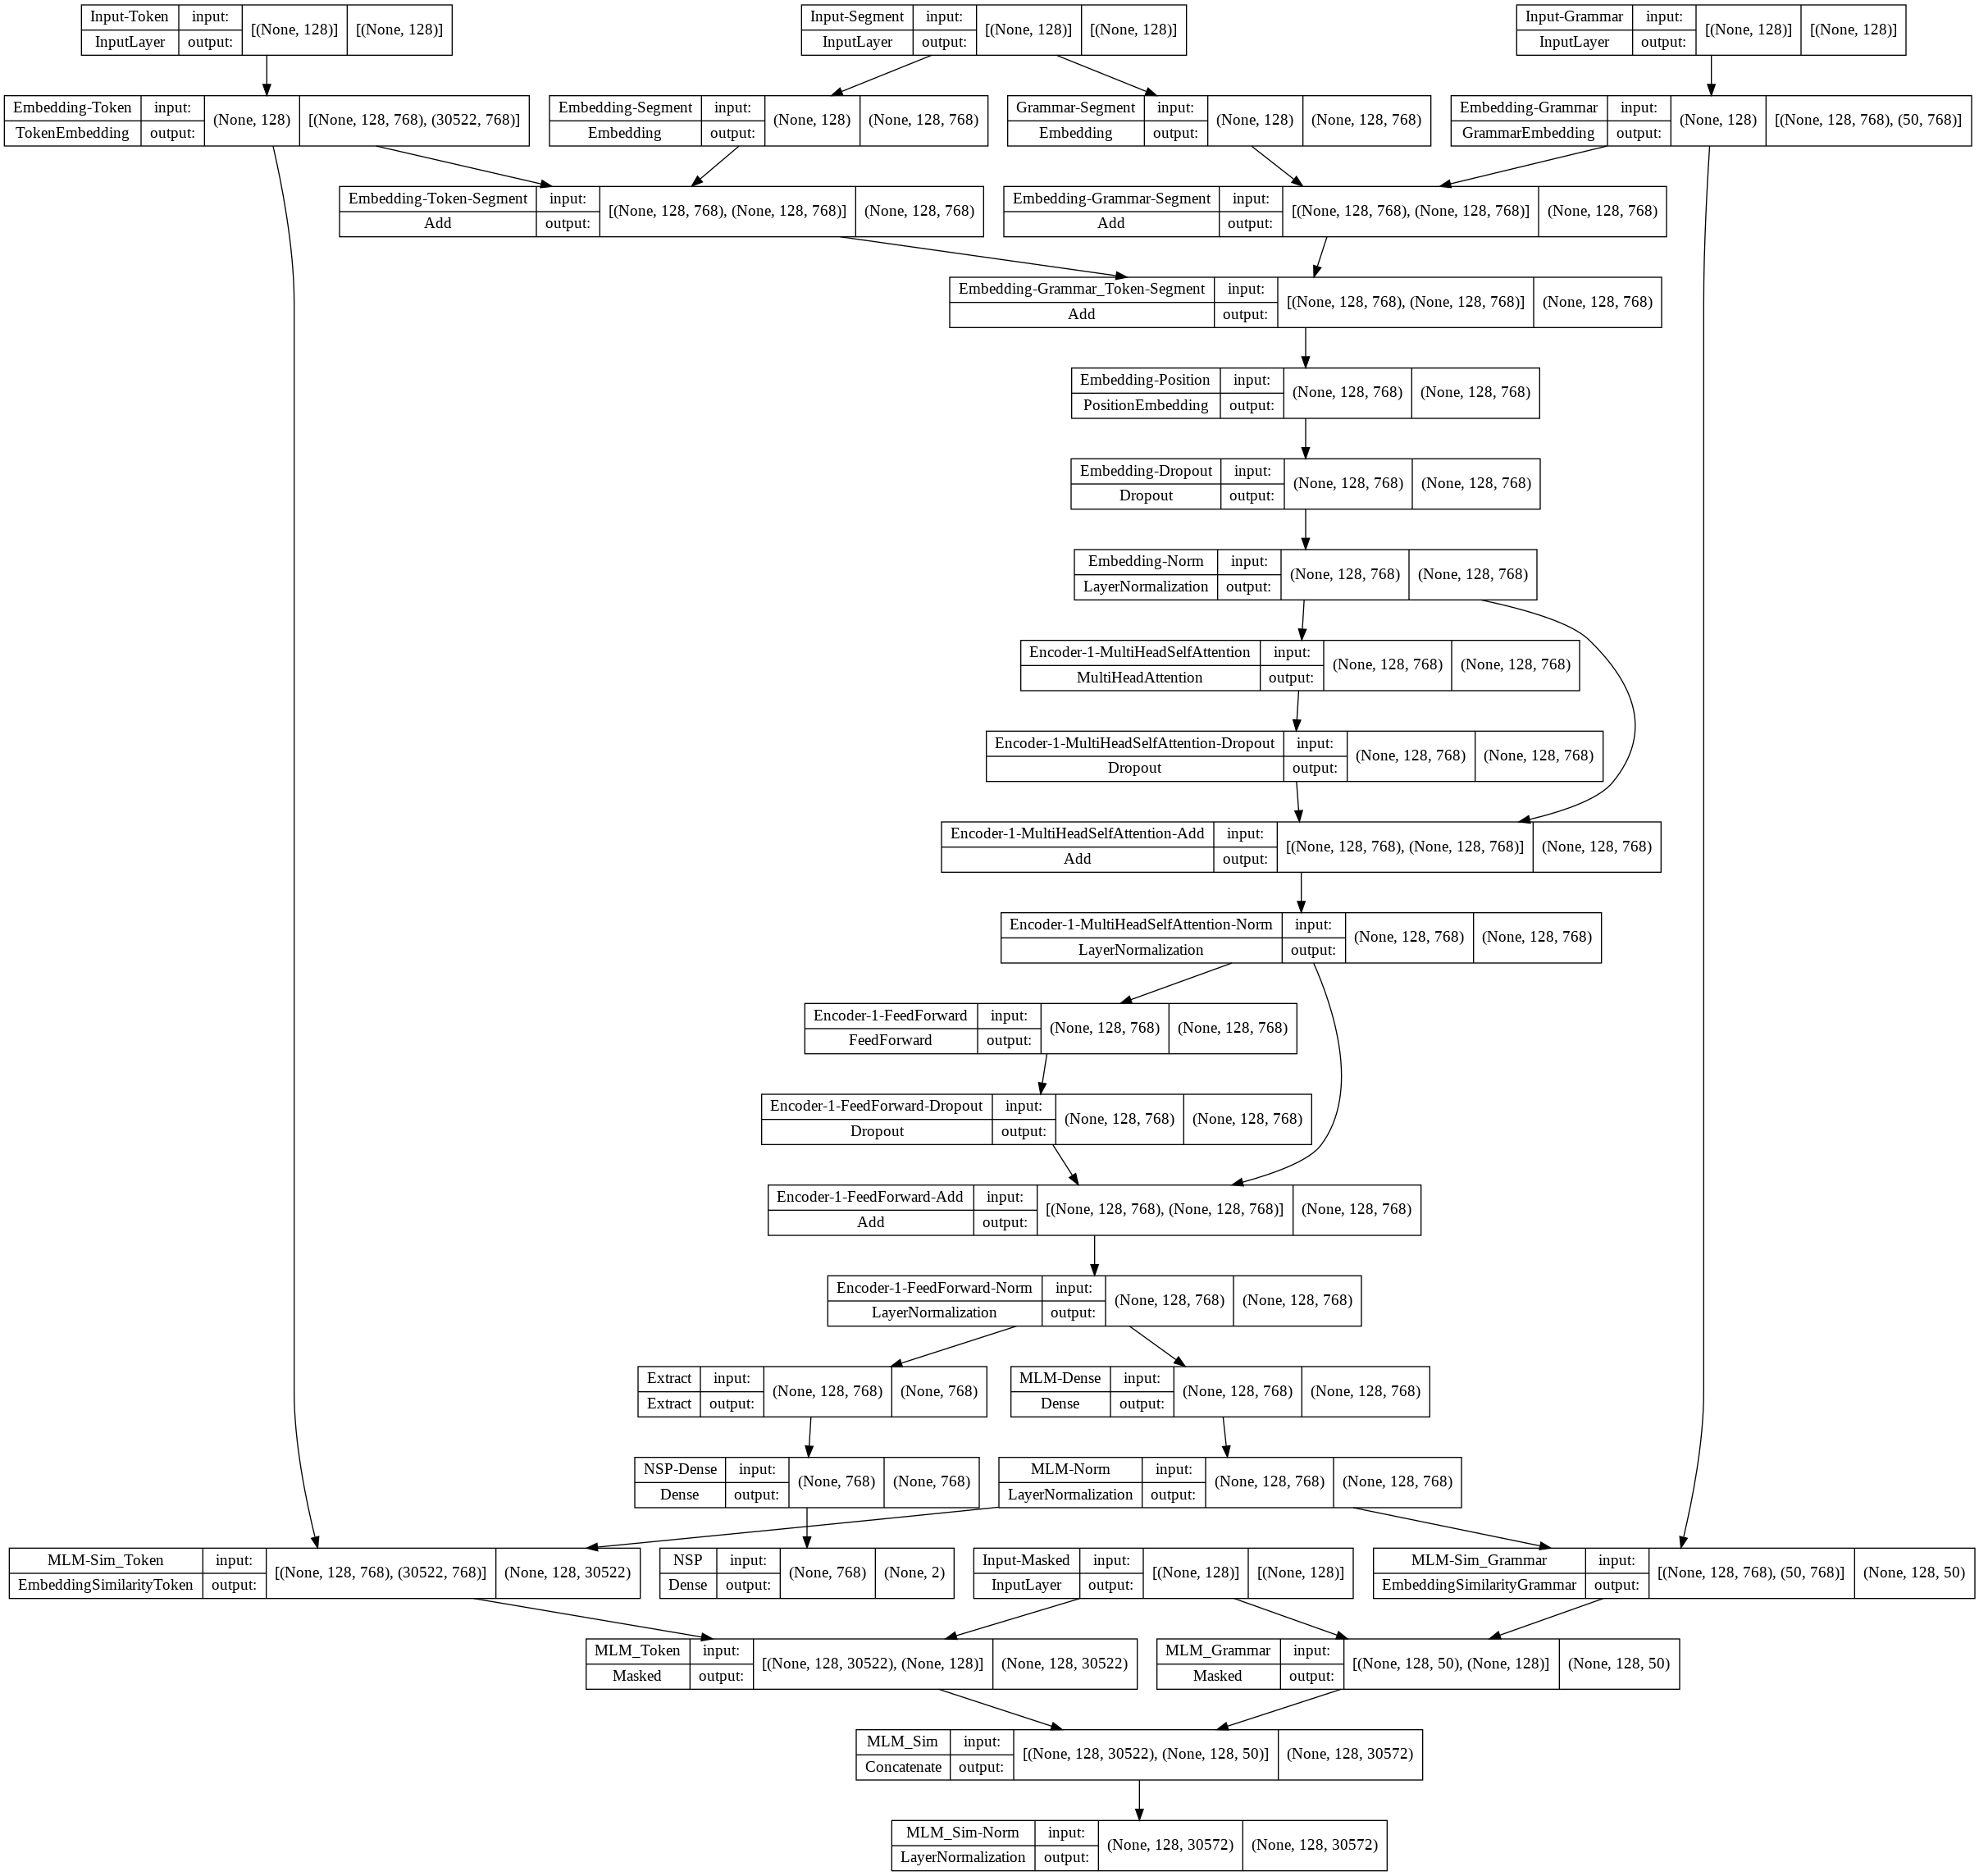

In [1110]:
keras.utils.plot_model(GELM, show_shapes=True)

In [887]:
keras.utils.plot_model(GELM, to_file='./GELM.pdf',show_shapes=True)

## Create Pre training data Section

### Tokenizer Section

In [888]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import collections
import re
import unicodedata
import six
import tensorflow as tf

def truncate_seq_pair(tokens_a, tokens_b, max_num_tokens, rng):
  """Truncates a pair of sequences to a maximum sequence length."""
  while True:
    total_length = len(tokens_a) + len(tokens_b)
    if total_length <= max_num_tokens:
      break

    trunc_tokens = tokens_a if len(tokens_a) > len(tokens_b) else tokens_b
    assert len(trunc_tokens) >= 1

    # We want to sometimes truncate from the front and sometimes from the
    # back to add more randomness and avoid biases.
    if rng.random() < 0.5:
      del trunc_tokens[0]
    else:
      trunc_tokens.pop()


def convert_to_unicode(text):
  """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text.decode("utf-8", "ignore")
    elif isinstance(text, unicode):
      return text
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")


def printable_text(text):
  """Returns text encoded in a way suitable for print or `tf.logging`."""

  # These functions want `str` for both Python2 and Python3, but in one case
  # it's a Unicode string and in the other it's a byte string.
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text
    elif isinstance(text, unicode):
      return text.encode("utf-8")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")

def load_vocab(vocab_file):
  """Loads a vocabulary file into a dictionary."""
  vocab = collections.OrderedDict()
  index = 0
  with tf.io.gfile.GFile(vocab_file, "r") as reader:
    while True:
      token = convert_to_unicode(reader.readline())
      if not token:
        break
      token = token.strip()
      vocab[token] = index
      index += 1
  return vocab

def load_grammar(grammar_file):
  """Loads a vocabulary file into a dictionary."""
  with open('/content/drive/MyDrive/Thesis/uncased_L-12_H-768_A-12/grammar.pickle', 'rb') as handle:
    grammarDict = pickle.load(handle)
    return(grammarDict)
    

def convert_by_vocab(vocab, items):
  """Converts a sequence of [tokens|ids] using the vocab."""
  output = []
  for item in items:
    output.append(vocab[item])
  return output

def convert_by_grammar(grammarDict, items):
  """Converts a sequence of [tokens|ids] using the vocab."""
  output = []
  for item in items:
    output.append(grammarDict[item])
  return output

def convert_grammar_to_ids(grammarDict, grammar):
  return convert_by_grammar(grammarDict, grammar)


def convert_ids_to_grammar(grammarDict, ids):
  inv_grammarDict = {v: k for k, v in grammarDict.items()}
  return convert_by_grammar(inv_grammarDict, ids)


def convert_tokens_to_ids(vocab, tokens):
  return convert_by_vocab(vocab, tokens)


def convert_ids_to_tokens(inv_vocab, ids):
  return convert_by_vocab(inv_vocab, ids)



def whitespace_tokenize(text):
  """Runs basic whitespace cleaning and splitting on a piece of text."""
  text = text.strip()
  if not text:
    return []
  tokens = text.split()
  return tokens

def clean_text(text):
  """Performs invalid character removal and whitespace cleanup on text."""
  output = []
  for char in text:
    cp = ord(char)
    if cp == 0 or cp == 0xfffd or _is_control(char):
      continue
    if _is_whitespace(char):
      output.append(" ")
    else:
      output.append(char)
  return "".join(output)


class FullTokenizer(object):
  """Runs end-to-end tokenziation."""

  def __init__(self, vocab_file, do_lower_case=True):
    self.vocab = load_vocab(vocab_file)
    self.inv_vocab = {v: k for k, v in self.vocab.items()}
    self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
    self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

  def tokenize(self, text):
    split_tokens = []
    for token in self.basic_tokenizer.tokenize(text):
      for sub_token in self.wordpiece_tokenizer.tokenize(token):
        split_tokens.append(sub_token)

    return split_tokens

  def convert_tokens_to_ids(self, tokens):
    return convert_by_vocab(self.vocab, tokens)

  def convert_ids_to_tokens(self, ids):
    return convert_by_vocab(self.inv_vocab, ids)


class BasicTokenizer(object):
  """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

  def __init__(self, do_lower_case=True):
    """Constructs a BasicTokenizer.
    Args:
      do_lower_case: Whether to lower case the input.
    """
    self.do_lower_case = do_lower_case

  def tokenize(self, text):
    """Tokenizes a piece of text."""
    text = convert_to_unicode(text)
    text = self._clean_text(text)
    text = self._tokenize_chinese_chars(text)
    orig_tokens = whitespace_tokenize(text)
    split_tokens = []
    for token in orig_tokens:
      if self.do_lower_case:
        token = token.lower()
        token = self._run_strip_accents(token)
      split_tokens.extend(self._run_split_on_punc(token))

    output_tokens = whitespace_tokenize(" ".join(split_tokens))
    return output_tokens

  def _run_strip_accents(self, text):
    """Strips accents from a piece of text."""
    text = unicodedata.normalize("NFD", text)
    output = []
    for char in text:
      cat = unicodedata.category(char)
      if cat == "Mn":
        continue
      output.append(char)
    return "".join(output)

  def _run_split_on_punc(self, text):
    """Splits punctuation on a piece of text."""
    chars = list(text)
    i = 0
    start_new_word = True
    output = []
    while i < len(chars):
      char = chars[i]
      if _is_punctuation(char):
        output.append([char])
        start_new_word = True
      else:
        if start_new_word:
          output.append([])
        start_new_word = False
        output[-1].append(char)
      i += 1

    return ["".join(x) for x in output]

  def _tokenize_chinese_chars(self, text):
    """Adds whitespace around any CJK character."""
    output = []
    for char in text:
      cp = ord(char)
      if self._is_chinese_char(cp):
        output.append(" ")
        output.append(char)
        output.append(" ")
      else:
        output.append(char)
    return "".join(output)

    return False

  def _clean_text(self, text):
    """Performs invalid character removal and whitespace cleanup on text."""
    output = []
    for char in text:
      cp = ord(char)
      if cp == 0 or cp == 0xfffd or _is_control(char):
        continue
      if _is_whitespace(char):
        output.append(" ")
      else:
        output.append(char)
    return "".join(output)

class WordpieceTokenizer(object):
  """Runs WordPiece tokenziation."""

  def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=200):
    self.vocab = vocab
    self.unk_token = unk_token
    self.max_input_chars_per_word = max_input_chars_per_word

  def tokenize(self, text):
    text = convert_to_unicode(text)
    output_tokens = []
    for token in whitespace_tokenize(text):
      chars = list(token)
      if len(chars) > self.max_input_chars_per_word:
        output_tokens.append(self.unk_token)
        continue
      is_bad = False
      start = 0
      sub_tokens = []
      while start < len(chars):
        end = len(chars)
        cur_substr = None
        while start < end:
          substr = "".join(chars[start:end])
          if start > 0:
            substr = "##" + substr
          if substr in self.vocab:
            cur_substr = substr
            break
          end -= 1
        if cur_substr is None:
          is_bad = True
          break
        sub_tokens.append(cur_substr)
        start = end

      if is_bad:
        output_tokens.append(self.unk_token)
      else:
        output_tokens.extend(sub_tokens)
    return output_tokens


def _is_whitespace(char):
  """Checks whether `chars` is a whitespace character."""
  # \t, \n, and \r are technically contorl characters but we treat them
  # as whitespace since they are generally considered as such.
  if char == " " or char == "\t" or char == "\n" or char == "\r":
    return True
  cat = unicodedata.category(char)
  if cat == "Zs":
    return True
  return False


def _is_control(char):
  """Checks whether `chars` is a control character."""
  # These are technically control characters but we count them as whitespace
  # characters.
  if char == "\t" or char == "\n" or char == "\r":
    return False
  cat = unicodedata.category(char)
  if cat in ("Cc", "Cf"):
    return True
  return False


def _is_punctuation(char):
  """Checks whether `chars` is a punctuation character."""
  cp = ord(char)

  if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
      (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
    return True
  cat = unicodedata.category(char)
  if cat.startswith("P"):
    return True
  return False

## Grammar file Section

In [ ]:
import nltk
nltk.download('tagsets')
from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')
len(tagdict.keys())


In [890]:
grammar_dict={'LS':1,'TO': 2,'VBN':3,"''":4,'WP':5,'UH':6,'VBG':7,'JJ': 8,'VBZ': 9,'--': 10,'VBP':11,
'NN':12,'DT': 13,'PRP': 14,':': 15,'WP$': 16,'NNPS': 17,'PRP$':18,'WDT': 19,'(': 20,')':21,'.':22,
',':23,'``':24,'$':25,'RB':26,'RBR':27,'RBS':28,'VBD':29,'IN':30,'FW':31,'RP':32,'JJR':33,'JJS': 34,
'PDT': 35,'MD': 36,'VB':37,'WRB': 38,'NNP':39,'EX':40,'NNS':41,'SYM': 42,'CC':43,'CD':44,'POS':45}


In [891]:
grammar_dict.keys()
with open('/content/drive/MyDrive/Thesis/uncased_L-12_H-768_A-12/grammar.pickle', 'wb') as handle:
    pickle.dump(grammar_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Training Instance Section

In [959]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

# import collections
# import re
# import unicodedata
# import six
# import tensorflow as tf
# '''
# input_ids = inputs["input_ids"]
# input_mask = inputs["attention_mask"]
# segment_ids = inputs["token_type_ids"]
# grammar_ids=inputs["grammar_ids"]
# masked_lm_positions = None
# masked_lm_ids = None
# masked_lm_weights = None
# next_sentence_labels = None

# num_warmup_steps=10
# num_train_steps=20 #10000 
# max_predictions_per_seq=20
# train_batch_size=32
# '''
# vocab_file=Newtokenizer.vocab #'/content/drive/MyDrive/Thesis/uncased_L-12_H-768_A-12/vocab.txt' #
# output_file='/content/drive/MyDrive/Thesis/Data/outputs/ '#tf_examples.tfrecord
# input_files= '/content/drive/MyDrive/Thesis/Data/Book/'
# all_files = os.listdir('/content/drive/MyDrive/Thesis/Data/Book/') 
# grammarfile='/content/drive/MyDrive/Thesis/uncased_L-12_H-768_A-12/grammar.pickle'
# do_lower_case=True
# do_whole_word_mask=True
# max_seq_length=128
# max_predictions_per_seq=20
# random_seed=12345
# dupe_factor=10
# masked_lm_prob=0.15
# short_seq_prob=0.1



# class TrainingInstance(object):
#   """A single training instance (sentence pair)."""

#   def __init__(self, tokens,grammars, segment_ids, masked_lm_positions, masked_lm_labels,
#                is_random_next):
#     self.tokens = tokens
#     self.grammars=grammars
#     self.segment_ids = segment_ids
#     self.is_random_next = is_random_next
#     self.masked_lm_positions = masked_lm_positions
#     self.masked_lm_labels = masked_lm_labels

#   def __str__(self):
#     s = ""
#     s += "tokens: %s\n" % (" ".join(
#         [printable_text(x) for x in self.tokens]))
#     s += "grammar: %s\n" % (" ".join(
#         [printable_text(x) for x in self.grammars]))
#     s += "segment_ids: %s\n" % (" ".join([str(x) for x in self.segment_ids]))
#     s += "is_random_next: %s\n" % self.is_random_next
#     s += "masked_lm_positions: %s\n" % (" ".join(
#         [str(x) for x in self.masked_lm_positions]))
#     s += "masked_lm_labels: %s\n" % (" ".join(
#         [printable_text(x) for x in self.masked_lm_labels]))
#     s += "\n"
#     return s
#   def __repr__(self):
#     return self.__str__()


### Creat instance from document Section

In [982]:

def create_instances_from_document(
    all_documents, all_grammars, document_index, max_seq_length, short_seq_prob,
    masked_lm_prob, max_predictions_per_seq, vocab_words, grammar_dict, rng):
  """Creates `TrainingInstance`s for a single document."""
  document = all_documents[0]
  grammars=all_grammars[0]
  # Account for [CLS], [SEP], [SEP]
  max_num_tokens = max_seq_length - 3

  # We *usually* want to fill up the entire sequence since we are padding
  # to `max_seq_length` anyways, so short sequences are generally wasted
  # computation. However, we *sometimes*
  # (i.e., short_seq_prob == 0.1 == 10% of the time) want to use shorter
  # sequences to minimize the mismatch between pre-training and fine-tuning.
  # The `target_seq_length` is just a rough target however, whereas
  # `max_seq_length` is a hard limit.
  target_seq_length = max_num_tokens
  if rng.random() < short_seq_prob:
    target_seq_length = rng.randint(2, max_num_tokens)

  # We DON'T just concatenate all of the tokens from a document into a long
  # sequence and choose an arbitrary split point because this would make the
  # next sentence prediction task too easy. Instead, we split the input into
  # segments "A" and "B" based on the actual "sentences" provided by the user
  # input.
  instances = []
  current_chunk = []
  current_length = 0
  current_g_chunk=[]
  current_g_length=0
  i = 0
  while i < len(document):
    segment = document[i]
    grammar=grammars[i]
    current_chunk.append(segment)
    current_length += len(segment)
    current_g_chunk.append(grammar)
    current_g_length += len(grammar)

    if i == len(document) - 1 or current_length >= target_seq_length:
      if current_chunk:
        # `a_end` is how many segments from `current_chunk` go into the `A`
        # (first) sentence.
        a_end = 1
        if len(current_chunk) >= 2:
          a_end = rng.randint(1, len(current_chunk) - 1)

        tokens_a = []
        grammars_a=[]
        for j in range(a_end):
          tokens_a.extend(current_chunk[j])
          grammars_a.extend(current_g_chunk[j])

        tokens_b = []
        grammars_b=[]
        # Random next
        is_random_next = False
        if len(current_chunk) == 1 or rng.random() < 0.5:
          is_random_next = True
          target_b_length = target_seq_length - len(tokens_a)

          # This should rarely go for more than one iteration for large
          # corpora. However, just to be careful, we try to make sure that
          # the random document is not the same as the document
          # we're processing.
          for _ in range(10):
            random_document_index = rng.randint(0, len(all_documents) - 1)
            if random_document_index != document_index:
              break

          random_document = all_documents[random_document_index]
          random_grammar=all_grammars[random_document_index]
          random_start = rng.randint(0, len(random_document) - 1)
          for j in range(random_start, len(random_document)):
            tokens_b.extend(random_document[j])
            grammars_b.extend(random_grammar[j])
            if len(tokens_b) >= target_b_length:
              break
          # We didn't actually use these segments so we "put them back" so
          # they don't go to waste.
          num_unused_segments = len(current_chunk) - a_end
          i -= num_unused_segments
        # Actual next
        else:
          is_random_next = False
          for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
        truncate_seq_pair(tokens_a, tokens_b, max_num_tokens, rng)
        truncate_seq_pair(grammars_a, grammars_b, max_num_tokens, rng)

        assert len(tokens_a) >= 1
        assert len(tokens_b) >= 1

        tokens = []
        grammars=[]
        segment_ids = []
        tokens.append("[CLS]")
        grammars.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
          tokens.append(token)
          segment_ids.append(0)
        for grammar in grammars_a:
          grammars.append(grammar)
        tokens.append("[SEP]")
        grammars.append("[SEP]")
        segment_ids.append(0)

        for token in tokens_b:
          tokens.append(token)
          segment_ids.append(1)
        tokens.append("[SEP]")
        segment_ids.append(1)

        for grammar in grammars_b:
          grammars.append(grammar)
          #segment_ids.append(1)
        grammars.append("[SEP]")
        #segment_ids.append(1)


        (tokens, grammars, masked_lm_positions,
          masked_t_labels,masked_g_labels) = create_masked_lm_predictions(
              tokens, grammars, masked_lm_prob, max_predictions_per_seq, vocab_words,grammar_dict, rng)
        instance = TrainingInstance(
            tokens=tokens,
            grammars=grammars,
            segment_ids=segment_ids,
            is_random_next=is_random_next,
            masked_lm_positions=masked_lm_positions,
            masked_t_labels=masked_t_labels,
            masked_g_labels=masked_g_labels)
        instances.append(instance)
      current_chunk = []
      current_length = 0
    i += 1

  return instances


MaskedLmInstance = collections.namedtuple("MaskedLmInstance",
                                          ["index","labeltoken" ,"labelgrammar"])



### create_masked_lm_predictions Section

In [990]:
def create_masked_lm_predictions(tokens,grammars, masked_lm_prob,
                                 max_predictions_per_seq, vocab_words, grammar_dict, rng):
  """Creates the predictions for the masked LM objective."""
  #inv_grammarDict = {v: k for k, v in grammarDict.items()}
  cand_indexes = []
  for (i, token) in enumerate(tokens):
    if token == "[CLS]" or token == "[SEP]":
      continue
    # Whole Word Masking means that if we mask all of the wordpieces
    # corresponding to an original word. When a word has been split into
    # WordPieces, the first token does not have any marker and any subsequence
    # tokens are prefixed with ##. So whenever we see the ## token, we
    # append it to the previous set of word indexes.
    #
    # Note that Whole Word Masking does *not* change the training code
    # at all -- we still predict each WordPiece independently, softmaxed
    # over the entire vocabulary.
    if (do_whole_word_mask and len(cand_indexes) >= 1 and
        token.startswith("##")):
      cand_indexes[-1].append(i)
    else:
      cand_indexes.append([i])

  rng.shuffle(cand_indexes)

  output_tokens = list(tokens)
  output_grammars = list(grammars)
  num_to_predict = min(max_predictions_per_seq,
                       max(1, int(round(len(tokens) * masked_lm_prob))))

  masked_lms = []
  masked_g=[]
  covered_indexes = set()
  for index_set in cand_indexes:
    if len(masked_lms) >= num_to_predict:
      break
    # If adding a whole-word mask would exceed the maximum number of
    # predictions, then just skip this candidate.
    if len(masked_lms) + len(index_set) > num_to_predict:
      continue
    is_any_index_covered = False
    for index in index_set:
      if index in covered_indexes:
        is_any_index_covered = True
        break
    if is_any_index_covered:
      continue
    for index in index_set:
      covered_indexes.add(index)

      masked_token = None
      masked_grammar=None
      # 80% of the time, replace with [MASK]
      if rng.random() < 0.8:
        masked_token = "[MASK]"
        masked_grammar= "[MASK]"
      else:
        # 10% of the time, keep original
        if rng.random() < 0.5:
          masked_token = tokens[index]
          masked_grammar = grammars[index]
        # 10% of the time, replace with random word
        else:
          masked_token = vocab_words[rng.randint(0, len(vocab_words) - 1)]
          masked_grammar = random.choice(list(grammar_dict))#inv_grammarDict[rng.randint(0, len(inv_grammarDict) - 1)]

      output_tokens[index] = masked_token
      output_grammars[index] = masked_grammar
      #MaskedLmInstance.labelgrammar
      masked_lms.append(MaskedLmInstance(index=index, labeltoken=tokens[index],labelgrammar=grammars[index]))
      masked_g.append(MaskedLmInstance(index=index, labeltoken=tokens[index],labelgrammar=grammars[index]))
  assert len(masked_lms) <= num_to_predict
  
  masked_lms = sorted(masked_lms, key=lambda x: x.index)
  masked_g= sorted(masked_g, key=lambda x: x.index)

  masked_lm_positions = []
  masked_t_labels = []
  masked_g_labels=[]
  for p in masked_lms:
    masked_lm_positions.append(p.index)
    masked_t_labels.append(p.labeltoken)
  for g in masked_g:
    masked_g_labels.append(g.labelgrammar)

  return (output_tokens,output_grammars, masked_lm_positions, masked_t_labels,masked_g_labels)


def truncate_seq_pair(tokens_a, tokens_b, max_num_tokens, rng):
  """Truncates a pair of sequences to a maximum sequence length."""
  while True:
    total_length = len(tokens_a) + len(tokens_b)
    if total_length <= max_num_tokens:
      break

    trunc_tokens = tokens_a if len(tokens_a) > len(tokens_b) else tokens_b
    assert len(trunc_tokens) >= 1

    # We want to sometimes truncate from the front and sometimes from the
    # back to add more randomness and avoid biases.
    if rng.random() < 0.5:
      del trunc_tokens[0]
    else:
      trunc_tokens.pop()

### write_instance_to_example_files Section

In [1067]:
def convert_gramamrs_to_ids(txt):
  Chunks=(('FENJJ',('JJ','JJR','JJS')),('FENMD',('MD')) ,('FENLS',('LS')),('FENNN',('NN','NNP','NNS','NNP$','NNPS')),('FENRB',('RB','RBR','RBS')), 
       ('FENPP',('PRP','PRP$','PP')),('FENVB',('VB','VBD','VBG','VBN','VBP','VBZ')),('FENWP',('WP','WP$')), 
       ('FENNP',('NP')), ('FENVP',('VP')),('FENPDT',('PDT','DT','WDT')),('FENPOS',('POS')),('FENSYM',('SYM')),
       ('FENCC',('CC')),('FENCD',('CD')),('FENEX',('EX')),('FENFW',('FW')),('FENIN',('IN')),
        ('FENTO',('TO')),('FENUH',('UH')), ('FENWR',('WRB','WRBS')) )
  
  Grammar_FE=[]
  for i in txt:
    if i=='[CLS]' or i=='[SEP]' or i=='[MASK]' or i== '[PAD]':
      Grammar_FE.append(i)
    else:
      try:
        if is_punctuation(i):
            Grammar_FE.append(i)  
      except:
        for j in Chunks:
          if i in j[1]:
              Grammar_FE.append(j[0])           
  return(Grammar_FE)

def is_punctuation(char):
  """Checks whether `chars` is a punctuation character."""
  cp = ord(char)

  if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
      (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
    return True
  cat = unicodedata.category(char)
  if cat.startswith("P"):
    return True
  return False

def write_instance_to_example_files(instances, tokenizer, grammarDict, max_seq_length,
                                    max_predictions_per_seq, output_files):
  """Create TF example files from `TrainingInstance`s."""

  writers = []
  for output_file in output_files:
    writers.append(tf.io.TFRecordWriter(output_file))

  writer_index = 0

  total_written = 0
  for (inst_index, instance) in enumerate(instances):

    input_ids = tokenizer.convert_tokens_to_ids(instance.tokens)
    Grammars_Pos=instance.grammars
    grammars=convert_gramamrs_to_ids(Grammars_Pos )
    grammars=[i.lower() for i in grammars]
    grammar_ids=tokenizer.convert_tokens_to_ids(grammars)
    input_mask = [1] * len(input_ids)
    segment_ids = list(instance.segment_ids)
    assert len(input_ids) <= max_seq_length

    while len(input_ids) < max_seq_length:
      input_ids.append(0)
      input_mask.append(0)
      segment_ids.append(0)
      grammar_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    assert len(grammar_ids) == max_seq_length

    masked_lm_positions = list(instance.masked_lm_positions)
    masked_lm_ids = tokenizer.convert_tokens_to_ids(instance.masked_t_labels)
    masked_g_ids=tokenizer.convert_tokens_to_ids(instance.masked_g_labels)
    masked_lm_weights = [1.0] * len(masked_lm_ids)
    masked_g_weights = [1.0] * len(masked_g_ids)

    while len(masked_lm_positions) < max_predictions_per_seq:
      masked_lm_positions.append(0)
      masked_lm_ids.append(0)
      masked_g_ids.append(0)
      masked_lm_weights.append(0.0)
      masked_g_weights.append(0.0)

    next_sentence_label = 1 if instance.is_random_next else 0

    features = collections.OrderedDict()
    #features["grammars"] = instance.grammars
    features["input_ids"] = create_int_feature(input_ids)
    features["input_mask"] = create_int_feature(input_mask)
    features["segment_ids"] = create_int_feature(segment_ids)
    features["grammar_ids"]= create_int_feature(grammar_ids)
    features["masked_lm_positions"] = create_int_feature(masked_lm_positions)
    features["masked_t_ids"] = create_int_feature(masked_lm_ids)
    features["masked_g_ids"] = create_int_feature(masked_g_ids)
    features["masked_lm_weights"] = create_float_feature(masked_lm_weights)
    features["masked_g_weights"] = create_float_feature(masked_g_weights)
    features["next_sentence_labels"] = create_int_feature([next_sentence_label])

    tf_example = tf.train.Example(features=tf.train.Features(feature=features))

    writers[writer_index].write(tf_example.SerializeToString())
    writer_index = (writer_index + 1) % len(writers)

    total_written += 1

    if inst_index < 20:
      print("*** Example ***")
      print("tokens: %s" % " ".join(
          [printable_text(x) for x in instance.tokens]))
      print("grammars: %s" % " ".join(
          [printable_text(x) for x in instance.grammars]))

      for feature_name in features.keys():
        feature = features[feature_name]
        values = []
        if feature.int64_list.value:
          values = feature.int64_list.value
        elif feature.float_list.value:
          values = feature.float_list.value
        print(
            "%s: %s" % (feature_name, " ".join([str(x) for x in values])))

  for writer in writers:
    writer.close()
  print("Wrote %d total instances", total_written)


def create_int_feature(values):
  feature = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
  return feature


def create_float_feature(values):
  feature = tf.train.Feature(float_list=tf.train.FloatList(value=list(values)))
  return feature


### Training Instance Section

In [1032]:
class TrainingInstance(object):
  """A single training instance (sentence pair)."""

  def __init__(self, tokens,grammars, segment_ids, masked_lm_positions, masked_t_labels,masked_g_labels,
               is_random_next):
    self.tokens = tokens
    self.grammars=grammars
    self.segment_ids = segment_ids
    self.is_random_next = is_random_next
    self.masked_lm_positions = masked_lm_positions
    self.masked_t_labels = masked_t_labels
    self.masked_g_labels=masked_g_labels

  def __str__(self):
    s = ""
    s += "tokens: %s\n" % (" ".join(
        [printable_text(x) for x in self.tokens]))
    s += "grammars: %s\n" % (" ".join(
        [printable_text(x) for x in self.grammars]))
    s += "segment_ids: %s\n" % (" ".join([str(x) for x in self.segment_ids]))
    s += "is_random_next: %s\n" % self.is_random_next
    s += "masked_lm_positions: %s\n" % (" ".join(
        [str(x) for x in self.masked_lm_positions]))
    s += "masked_token_labels: %s\n" % (" ".join(
        [printable_text(x) for x in self.masked_t_labels]))
    s += "masked_grammar_labels: %s\n" % (" ".join(
        [printable_text(x) for x in self.masked_g_labels]))
    s += "\n"
    return s
  def __repr__(self):
    return self.__str__()


### create_training_instances Section

In [988]:
def create_training_instances(input_files,grammarfile, tokenizer, max_seq_length,
                              dupe_factor, short_seq_prob, masked_lm_prob,
                              max_predictions_per_seq, rng):

  """Create `TrainingInstance`s from raw text."""
  all_documents = [[]]

  # Input file format:
  # (1) One sentence per line. These should ideally be actual sentences, not
  # entire paragraphs or arbitrary spans of text. (Because we use the
  # sentence boundaries for the "next sentence prediction" task).
  # (2) Blank lines between documents. Document boundaries are needed so
  # that the "next sentence prediction" task doesn't span between documents.
  grammar_dict=load_grammar(grammarfile)
  all_documents = [[]]
  all_grammars=[[]]
  input_file= input_files#'/content/drive/MyDrive/Thesis/Data/sample.txt'#/content/drive/MyDrive/Thesis/Data/sample.txt'
  with tf.io.gfile.GFile(input_file, "r") as reader:
    #while True:
    with open(input_file, 'rb') as f:
      line= f.read()
      if not line:
        pass
      line = line.strip()
      # Empty lines are used as document delimiters
    if not line:
        all_documents.append([])
        all_grammars.append([])
    txt=printable_text(line)
    clean_txt=clean_text(txt)
    tokens = Newtokenizer.tokenize(clean_txt)
    grammars=Convert_to_POS(clean_txt)

    if tokens:
      all_documents[-1].append(tokens)
      all_grammars[-1].append(grammars)

  rng = random.Random(random_seed)
  # Remove empty documents
  all_documents = [x for x in all_documents if x]

  all_grammars= [x for x in all_grammars if x]
  rng.shuffle(all_documents)

  vocab_words = list(Newtokenizer.vocab.keys())
  grammar_words=list(grammar_dict.keys())

  instances = []
  for _ in range(dupe_factor):
    for document_index in range(len(all_documents)):
      instances.extend(
          create_instances_from_document(
              all_documents, all_grammars, document_index, max_seq_length, short_seq_prob,
              masked_lm_prob, max_predictions_per_seq, vocab_words,grammar_dict, rng))

  rng.shuffle(instances)
  return instances

In [972]:
def Convert_to_POS(txt):
  bert_tokens = []
  Bert_Tags = []
  Tokens = nltk.word_tokenize(txt)
  Tags = pos_tag(Tokens)
  for j,orig_token in enumerate(Tokens):
    bert_tokens.extend(Newtokenizer.tokenize(orig_token))
    tags=Newtokenizer.tokenize(orig_token)
    for tag in tags:
      Bert_Tags.append((tag,Tags[j][1]))
  Grammar_FE=[i[1] for i in Bert_Tags]

  return(Grammar_FE)

# test create pretraining Section

In [1112]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import re
import unicodedata
import six
import tensorflow as tf
'''
input_ids = inputs["input_ids"]
input_mask = inputs["attention_mask"]
segment_ids = inputs["token_type_ids"]
grammar_ids=inputs["grammar_ids"]
masked_lm_positions = None
masked_lm_ids = None
masked_lm_weights = None
next_sentence_labels = None

num_warmup_steps=10
num_train_steps=20 #10000 
max_predictions_per_seq=20
train_batch_size=32
'''
vocab_file='/content/drive/MyDrive/Thesis/uncased_L-12_H-768_A-12/vocab.txt' #Newtokenizer.vocab
output_file='/content/drive/MyDrive/Thesis/Data/output/tf_examples.tfrecord '
input_file= '/content/drive/MyDrive/Thesis/Data/sample.txt'
grammarfile='/content/drive/MyDrive/Thesis/uncased_L-12_H-768_A-12/grammar.pickle'

do_lower_case=True
do_whole_word_mask=True
max_seq_length=128
max_predictions_per_seq=20
random_seed=12345
dupe_factor=10
masked_lm_prob=0.15
short_seq_prob=0.1

In [1113]:
Chunks=(('FENJJ',('JJ','JJR','JJS')),('FENMD',('MD')) ,('FENLS',('LS')),('FENNN',('NN','NNP','NNS','NNP$','NNPS')),('FENRB',('RB','RBR','RBS')), 
       ('FENPP',('PRP','PRP$','PP')),('FENVB',('VB','VBD','VBG','VBN','VBP','VBZ')),('FENWP',('WP','WP$')), 
       ('FENNP',('NP')), ('FENVP',('VP')),('FENPDT',('PDT','DT','WDT')),('FENPOS',('POS')),('FENSYM',('SYM')),
       ('FENCC',('CC')),('FENCD',('CD')),('FENEX',('EX')),('FENFW',('FW')),('FENIN',('IN')),
        ('FENTO',('TO')),('FENUH',('UH')), ('FENWR',('WRB','WRBS')) )

def convert_by_grammar(grammarDict, items):
  """Converts a sequence of [tokens|ids] using the vocab."""
  output = []
  for item in items:
    output.append(grammarDict[item])
  return output

def convert_grammar_to_ids(grammarDict, grammar):
  return convert_by_grammar(grammarDict, grammar)

def load_grammar(grammar_file):
  """Loads a vocabulary file into a dictionary."""
  with open('/content/drive/MyDrive/Thesis/uncased_L-12_H-768_A-12/grammar.pickle', 'rb') as handle:
    grammarDict = pickle.load(handle)
    return(grammarDict)

grammar_Dict=load_grammar(grammarfile)

rng = random.Random(random_seed)
instances = create_training_instances(
  input_file,grammarfile, Newtokenizer, max_seq_length, dupe_factor,
  short_seq_prob, masked_lm_prob, max_predictions_per_seq,
  rng)

output_files = output_file.split(",")
print("*** Writing to output files ***")
for output_file in output_files:
  print("  writing: {}" .format(output_file))

  write_instance_to_example_files(instances, Newtokenizer,grammar_Dict, max_seq_length,
                                max_predictions_per_seq, output_files)


*** Writing to output files ***
  writing: /content/drive/MyDrive/Thesis/Data/output/tf_examples.tfrecord 


AssertionError: ignored

In [ ]:
Chunks=(('FENJJ',('JJ','JJR','JJS')),('FENMD',('MD')) ,('FENLS',('LS')),('FENNN',('NN','NNP','NNS','NNP$','NNPS')),('FENRB',('RB','RBR','RBS')), 
      ('FENPP',('PRP','PRP$','PP')),('FENVB',('VB','VBD','VBG','VBN','VBP','VBZ')),('FENWP',('WP','WP$')), 
      ('FENNP',('NP')), ('FENVP',('VP')),('FENPDT',('PDT','DT','WDT')),('FENPOS',('POS')),('FENSYM',('SYM')),
      ('FENCC',('CC')),('FENCD',('CD')),('FENEX',('EX')),('FENFW',('FW')),('FENIN',('IN')),
      ('FENTO',('TO')),('FENUH',('UH')), ('FENWR',('WRB','WRBS')) )

Grammar_FE=[]
for i in txt:
  if i=='[CLS]' or i=='[SEP]' or i=='[MASK]' or i== '[PAD]':
    Grammar_FE.append(i)
  else:
    try:
      if is_punctuation(i):
          Grammar_FE.append(i)  
    except:
      for j in Chunks:
        if i in j[1]:
            Grammar_FE.append(j[0]) 

In [1104]:
grammars=convert_gramamrs_to_ids(Grammars_Pos )
len(Grammars_Pos)

128

In [1100]:
input_ids = Newtokenizer.convert_tokens_to_ids(instance.tokens)
Grammars_Pos=instance.grammars
grammars=convert_gramamrs_to_ids(Grammars_Pos )
grammars=[i.lower() for i in grammars]
grammar_ids=Newtokenizer.convert_tokens_to_ids(grammars)
input_mask = [1] * len(input_ids)
segment_ids = list(instance.segment_ids)
assert len(input_ids) <= max_seq_length

while len(input_ids) < max_seq_length:
  input_ids.append(0)
  input_mask.append(0)
  segment_ids.append(0)
  grammar_ids.append(0)

assert len(input_ids) == max_seq_length
assert len(input_mask) == max_seq_length
assert len(segment_ids) == max_seq_length
assert len(grammar_ids) == max_seq_length

masked_lm_positions = list(instance.masked_lm_positions)
masked_lm_ids = tokenizer.convert_tokens_to_ids(instance.masked_t_labels)
masked_g_ids=tokenizer.convert_tokens_to_ids(instance.masked_g_labels)
masked_lm_weights = [1.0] * len(masked_lm_ids)
masked_g_weights = [1.0] * len(masked_g_ids)

while len(masked_lm_positions) < max_predictions_per_seq:
  masked_lm_positions.append(0)
  masked_lm_ids.append(0)
  masked_g_ids.append(0)
  masked_lm_weights.append(0.0)
  masked_g_weights.append(0.0)

next_sentence_label = 1 if instance.is_random_next else 0

features = collections.OrderedDict()
#features["grammars"] = instance.grammars
features["input_ids"] = create_int_feature(input_ids)
features["input_mask"] = create_int_feature(input_mask)
features["segment_ids"] = create_int_feature(segment_ids)
features["grammar_ids"]= create_int_feature(grammar_ids)
features["masked_lm_positions"] = create_int_feature(masked_lm_positions)
features["masked_t_ids"] = create_int_feature(masked_lm_ids)
features["masked_g_ids"] = create_int_feature(masked_g_ids)
features["masked_lm_weights"] = create_float_feature(masked_lm_weights)
features["masked_g_weights"] = create_float_feature(masked_g_weights)
features["next_sentence_labels"] = create_int_feature([next_sentence_label])

tf_example = tf.train.Example(features=tf.train.Features(feature=features))

writers[writer_index].write(tf_example.SerializeToString())
writer_index = (writer_index + 1) % len(writers)

total_written += 1

if inst_index < 20:
  print("*** Example ***")
  print("tokens: %s" % " ".join(
      [printable_text(x) for x in instance.tokens]))
  print("grammars: %s" % " ".join(
      [printable_text(x) for x in instance.grammars]))

  for feature_name in features.keys():
    feature = features[feature_name]
    values = []
    if feature.int64_list.value:
      values = feature.int64_list.value
    elif feature.float_list.value:
      values = feature.float_list.value
    print(
        "%s: %s" % (feature_name, " ".join([str(x) for x in values])))

AssertionError: ignored

In [1108]:
instances[0]

tokens: [CLS] ##tf ##re ##cor ##df ##ile format [MASK] you can perform sentence segment ##ation with an off - [MASK] - shelf nl ##p tool ##kit such ass ##pac ##y [MASK] the ##cre ##ate _ pre ##train ##ing _ data [MASK] p ##ys ##cript will con ##cate ##nate segments until they reach the maximum sequence length to minimize computational waste from pad ##ding audiences [MASK] [SEP] . you [MASK] perform sentence [MASK] [MASK] with [MASK] off - the [MASK] shelf nl ##p tool ##kit such ass ##pac ##y . [MASK] [MASK] [MASK] _ pre ##train ##ing _ [MASK] . p ##ys ##cript will con ##cate ##nate segments [MASK] they reach the maximum sequence length [MASK] minimize computational waste from pad ##ding ( see the script for more details [SEP]
grammars: [CLS] IN JJ NNS . DT NN [MASK] DT NN VBZ VBZ VBZ VBZ VBZ VBZ VBN JJ [MASK] JJ JJ JJ JJ NN . PRP MD VB NN [MASK] NN IN DT JJ JJ JJ JJ JJ NNP [MASK] NN NN JJ NN NN NN . NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP MD VB VBP [MASK] [SEP] JJ JJ [MASK

## create batches Section

In [ ]:
mask_rate=0.15
mask_mask_rate=0.8
mask_random_rate=0.1
swap_sentence_rate=0.5
force_mask=True
batch_size = len(input_encodes)#len(sentence_pairs)
unknown_index = Newtokenizer.convert_tokens_to_ids('[UNK]')
# Generate sentence swapping mapping
nsp_outputs = np.zeros((batch_size,))
mapping = {}
if swap_sentence_rate > 0.0:
    indices = [index for index in range(batch_size) if np.random.random() < swap_sentence_rate]
    mapped = indices[:]
    np.random.shuffle(mapped)
    for i in range(len(mapped)):
        if indices[i] != mapped[i]:
            nsp_outputs[indices[i]] = 1.0
    mapping = {indices[i]: mapped[i] for i in range(len(indices))}
mapping

{0: 2, 2: 0}